### Case Study ABEA

[description to be added]

### Setup

In [1]:
import sys
sys.path.insert(0, 'GRACE/')                                       # Add 'GRACE/' directory at the start of the sys.path for module searching
import os                                                          # used to interact with the operating system
import argparse                                                    # for parsing command line arguments
import random                                                      # to generate random numbers
import numpy as np                                                 # for numerical and array operations
import pandas as pd                                                # for data manipulation and analysis
from datetime import datetime, timedelta                           # for date and time manipulation
import time                                                        # used for adding a break in between the processing of data chunks
import math                                                        # used to ensure a numeric operation is kept in integer rather than float
import urllib.request                                              # Functions for opening URLs
import requests                                                    # For accessing url images
from io import BytesIO                                             # For accessing url images
from collections import Counter                                    # for counting hashable objects
import re                                                          # for regular expression operations
import nltk                                                        # Natural Language Toolkit
from nltk.corpus import stopwords                                  # NLTK stopwords list
from nltk.tokenize import word_tokenize                            # Tokenizer from NLTK

# Geographic/ spatial packages
import geopandas as gpd                                            # Geographic data handling
from shapely import wkb, wkt                                       # Creating and parsing geospatial data
from shapely.geometry import Point, Polygon, shape                 # Creating geospatial data
from shapely.wkb import loads
import folium                                                      # Interactive mapping capabilities
import folium.plugins as plugins                                   # Interactive mapping capabilities
import contextily                                                  # Context geo-tiles in Python                                    

# Plotting Data
import matplotlib.pyplot as plt                                    # A plotting library for creating static, interactive, and animated visualizations in Python
import matplotlib.ticker as ticker                                 # Provides classes for configuring tick locating and formatting
from matplotlib.ticker import MaxNLocator, FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import seaborn as sns; sns.set(style="ticks", color_codes=True)    # Statistical data visualization
import plotly                                                      # An open-source interactive data visualization library
import plotly.express as px                                        # for interactive, animated timeseries map
import wordcloud                                                   # A wordcloud generator
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS    # Wordcloud utilities
from PIL import Image                                              # For masking wordcloud with an image

# PyTorch and GRACE-Specific Packages
import torch                                                       # A deep learning framework for tensor computations and automatic differentiation
import torch.nn.functional as F                                    # torch.nn.functional is for activation and loss functions in pytorch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset # PyTorch classes for data handling, sampling, batching, etc.
from tokenization import BertTokenizer                             # For tokenizing text into tokens understandable by BERT
from ate_asc_modeling_local_bert_file import BertForSequenceLabeling # Import local files from the GRACE folder in this repo
import ate_asc_modeling_local_bert_file                            # Local file containing BERT modeling utilities for ATE and ASC
from file_utils import PYTORCH_PRETRAINED_BERT_CACHE               # PYTORCH_PRETRAINED_BERT_CACHE to manage caching for pre-trained BERT models
from ate_asc_features import ATEASCProcessor, convert_examples_to_features, get_labels
from tqdm import tqdm                                              # for progress monitoring
import argparse 

import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the Case Study Data 

This twitter data has already been pre-processed into a GDF and checked for polygon size (<1000 square miles), and converted to centroid point geometry. 

In [4]:
# load case study gdf
gdf_points = gpd.read_file('Data/Case Study Data/tweets_all_cali_2020_as_points_gdf.geojson')
print(len(gdf_points))
gdf_points.head(2)

09/22/2024 14:05:39 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:05:51 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:06:12 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:06:42 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:07:22 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:08:04 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:08:20 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 14:08:27 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


27055140


,Unnamed: 0,message_id,date,text,geom_type,lat,lon,geometry
0,0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,Point,-438410.079556,162056.364451,POINT (162056.36445 -438410.07956)
1,1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,Polygon,-471605.252277,151979.327340,POINT (151979.32734 -471605.25228)


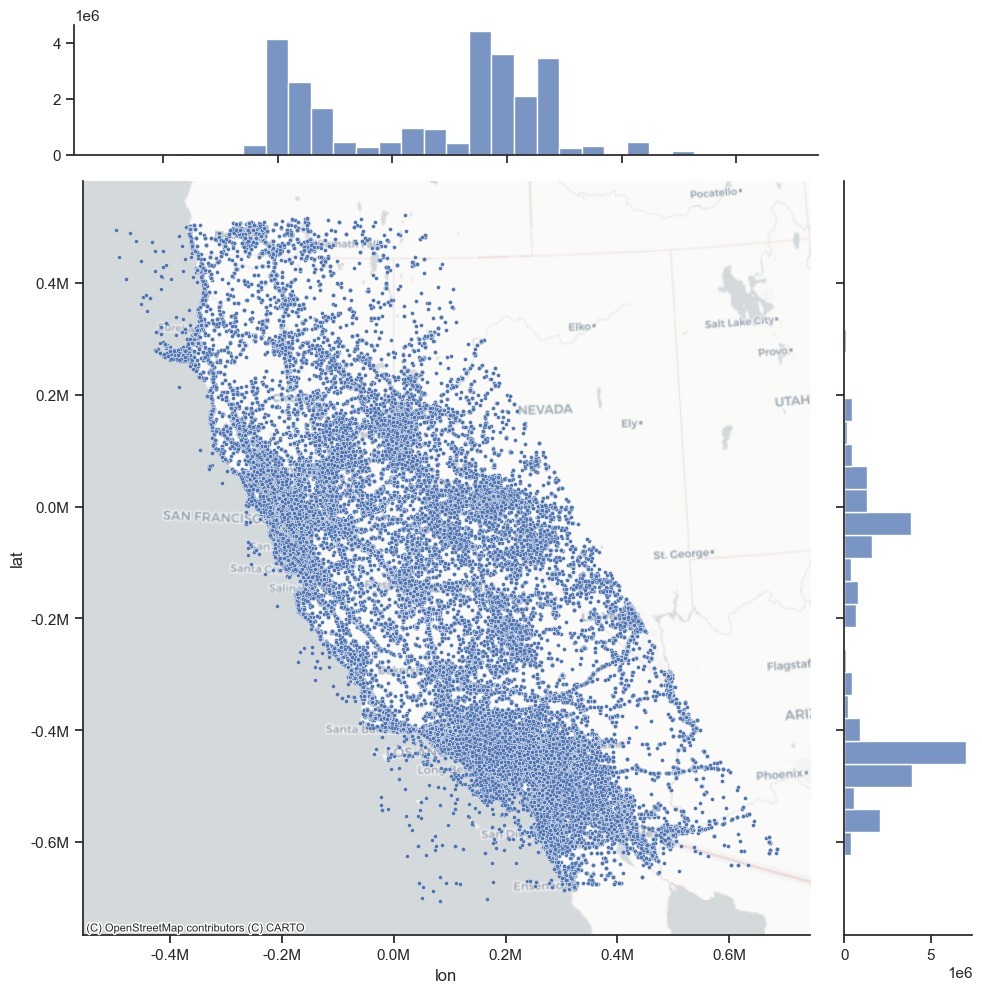

In [8]:
# check point data

# format numbers in millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


# jointplot with base map to show spatial distribution
joint_axes = sns.jointplot(
    x=gdf_points["lon"],
    y=gdf_points["lat"],
    data=gdf_points,
    s=8,
    height=10,
    ratio=5,  # ratio for size of bar charts on top and right
    marginal_ticks=True, 
    marginal_kws=dict(bins=30) # nr of bins
)

formatter = FuncFormatter(millions)
joint_axes.ax_marg_x.xaxis.set_major_formatter(formatter)
joint_axes.ax_marg_y.yaxis.set_major_formatter(formatter)

contextily.add_basemap(
    joint_axes.ax_joint, # join the basemap with the plot
    crs='EPSG:3310', # specify CRS
    source=contextily.providers.CartoDB.Positron 
)


In [9]:
# load wildfire json into gdf
wildfires_gdf = gpd.read_file('Data/Case Study Data/top_10_largest_fires.json')
print('Loaded the wildfire dataset into a gdf.')

# check the date columns to see their format
# wildfires_gdf[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE']].head(2)

# converet unix timestamps to datetime
wildfires_gdf['ALARM_DATE'] = pd.to_datetime(wildfires_gdf['ALARM_DATE'], unit='ms')
wildfires_gdf['CONT_DATE'] = pd.to_datetime(wildfires_gdf['CONT_DATE'], unit='ms')

# verify date conversion
wildfires_gdf[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE']].head(2)

09/22/2024 15:22:54 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:54 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:54 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:54 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:54 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:55 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:55 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 15:22:55 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


Loaded the wildfire dataset into a gdf.


,FIRE_NAME,ALARM_DATE,CONT_DATE
0,SCU COMPLEX,2020-08-16,2020-09-11
1,BOBCAT,2020-09-06,2020-10-19


Wildfire CRS now: EPSG:4326
GDF for the tweets CRS now: EPSG:3310
Wildfire CRS after reprojecting: EPSG:3310


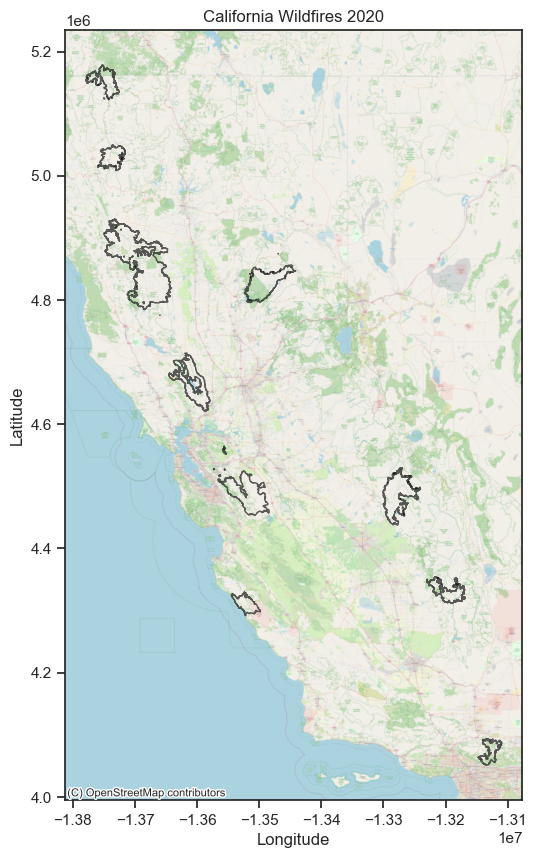

In [10]:
# set CRS for wildfire data to EPSG:4326
wildfires_gdf = wildfires_gdf.set_crs(epsg=4326, allow_override=True)
print(f'Wildfire CRS now: {wildfires_gdf.crs}')

# set CRS for points data to EPSG:3310
gdf_points = gdf_points.set_crs(epsg=3310, allow_override=True)
print(f'GDF for the tweets CRS now: {gdf_points.crs}')

# Reproject wildfire data to EPSG:3310
wildfires_gdf = wildfires_gdf.to_crs(epsg=3310)
print(f'Wildfire CRS after reprojecting: {wildfires_gdf.crs}')

# check that the fires are loaded correctly
wildfires_copy_gdf = wildfires_gdf.copy()

# Convert the CRS to EPSG:3857 for plotting with basemap
wildfires_copy_gdf = wildfires_copy_gdf.to_crs(epsg=3857)

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
wildfires_copy_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.7)

# basemap
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, zoom=10)

# title and labels
plt.title('California Wildfires 2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Create Tweet Subsets for the Specific Fires

Subset 1: During and Near Fire

Subset 2: NOT during and near Fire

Subset 3: During and Not near Fire (similar size to subset 1)


In [238]:
#               0               1           2           3           4           5           6       7           8                   9
fire_names = ['SCU COMPLEX', 'BOBCAT', 'HENNESSEY', 'DOLAN', 'NORTH COMPLEX', 'CASTLE', 'CREEK', 'SLATER', 'AUGUST COMPLEX', 'RED SALMON COMPLEX']

# which fire to create subsets and analyses for
specific_fire_name = fire_names[3]
print(specific_fire_name)

DOLAN


In [239]:
# buffer distance in meters (30000 meters = 30 km)
buffer_distance = 30000

# Convert the date column to datetime in the tweets GeoDataFrame
gdf_points['date'] = pd.to_datetime(gdf_points['date'])

# empty GeoDataFrames to hold results
tweets_during_near_fire_gdf = gpd.GeoDataFrame(columns=gdf_points.columns, crs=gdf_points.crs)
tweets_not_during_near_fire_gdf = gpd.GeoDataFrame(columns=gdf_points.columns, crs=gdf_points.crs)
tweets_during_not_near_fire_gdf = gpd.GeoDataFrame(columns=gdf_points.columns, crs=gdf_points.crs)

# Filter wildfires_gdf to only include the specific fire name
specific_fire = wildfires_gdf[wildfires_gdf['FIRE_NAME'] == specific_fire_name]

# Ensure there is only one fire matching the name
if specific_fire.shape[0] == 1:
    fire = specific_fire.iloc[0]
    fire_polygon = fire.geometry
    containment_date = pd.to_datetime(fire['CONT_DATE'])
    alarm_date = pd.to_datetime(fire['ALARM_DATE'])
    fire_name = fire['FIRE_NAME']
    print(f"Searching for tweets related to the {fire['FIRE_NAME']} fire.\nStarted: {alarm_date}\nContained: {containment_date}")

    # Skip if dates are NaT (Not a Time)
    if not pd.isna(alarm_date) and not pd.isna(containment_date):
        # Set a buffer around the fire polygon
        fire_buffer = fire_polygon.buffer(buffer_distance)
        
        # Subset 1: During and Near Fire
        date_mask_during_fire = (gdf_points['date'] >= alarm_date) & (gdf_points['date'] <= containment_date + timedelta(days=14))
        spatial_mask_near_fire = gdf_points.intersects(fire_polygon) | gdf_points.intersects(fire_buffer)
        tweets_during_near_fire_gdf = gdf_points[date_mask_during_fire & spatial_mask_near_fire]
        
        # Subset 2: NOT During and Near Fire
        date_mask_not_during_fire = (gdf_points['date'] < alarm_date) | (gdf_points['date'] > containment_date + timedelta(days=14))
        tweets_not_during_near_fire_gdf = gdf_points[date_mask_not_during_fire & spatial_mask_near_fire]
        
        # Subset 3: During and Not Near Fire
        spatial_mask_not_near_fire = ~spatial_mask_near_fire
        tweets_during_not_near_fire_gdf = gdf_points[date_mask_during_fire & spatial_mask_not_near_fire]
        
        # Randomly sample Subset 2 to match the size of Subset 1
        if len(tweets_not_during_near_fire_gdf) > len(tweets_during_near_fire_gdf):
            tweets_not_during_near_fire_gdf = tweets_not_during_near_fire_gdf.sample(n=len(tweets_during_near_fire_gdf), random_state=42)
        
        # Randomly sample Subset 3 to match the size of Subset 1
        if len(tweets_during_not_near_fire_gdf) > len(tweets_during_near_fire_gdf):
            tweets_during_not_near_fire_gdf = tweets_during_not_near_fire_gdf.sample(n=len(tweets_during_near_fire_gdf), random_state=42)

    # Reset the index of the result GeoDataFrames
    tweets_during_near_fire_gdf = tweets_during_near_fire_gdf.reset_index(drop=True)
    tweets_not_during_near_fire_gdf = tweets_not_during_near_fire_gdf.reset_index(drop=True)
    tweets_during_not_near_fire_gdf = tweets_during_not_near_fire_gdf.reset_index(drop=True)

    print(f"Subset 1 (During and Near Fire): {len(tweets_during_near_fire_gdf)} tweets")
    print(f"Subset 2 (NOT During and Near Fire): {len(tweets_not_during_near_fire_gdf)} tweets")
    print(f"Subset 3 (During and Not Near Fire): {len(tweets_during_not_near_fire_gdf)} tweets")
else:
    print(f"No unique fire found with the name '{specific_fire_name}'. Please check the fire name or ensure there is only one fire with that name.")

Searching for tweets related to the DOLAN fire.
Started: 2020-08-18 00:00:00
Contained: 2020-12-31 00:00:00


KeyboardInterrupt: 

In [47]:
subsets = [tweets_during_near_fire_gdf, tweets_not_during_near_fire_gdf, tweets_during_not_near_fire_gdf]
names = [f'{specific_fire_name}_during_and_near', f'{specific_fire_name}_not_during_and_near', f'{specific_fire_name}_during_and_not_near']

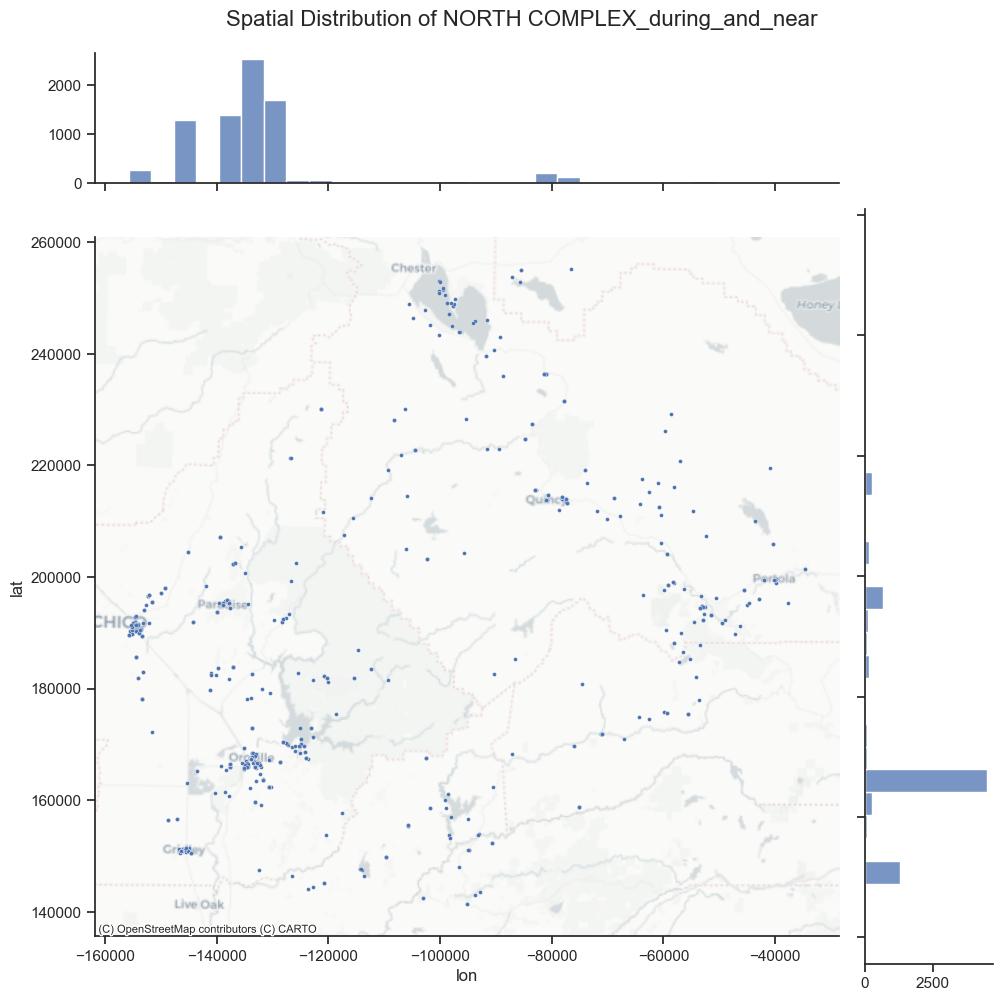

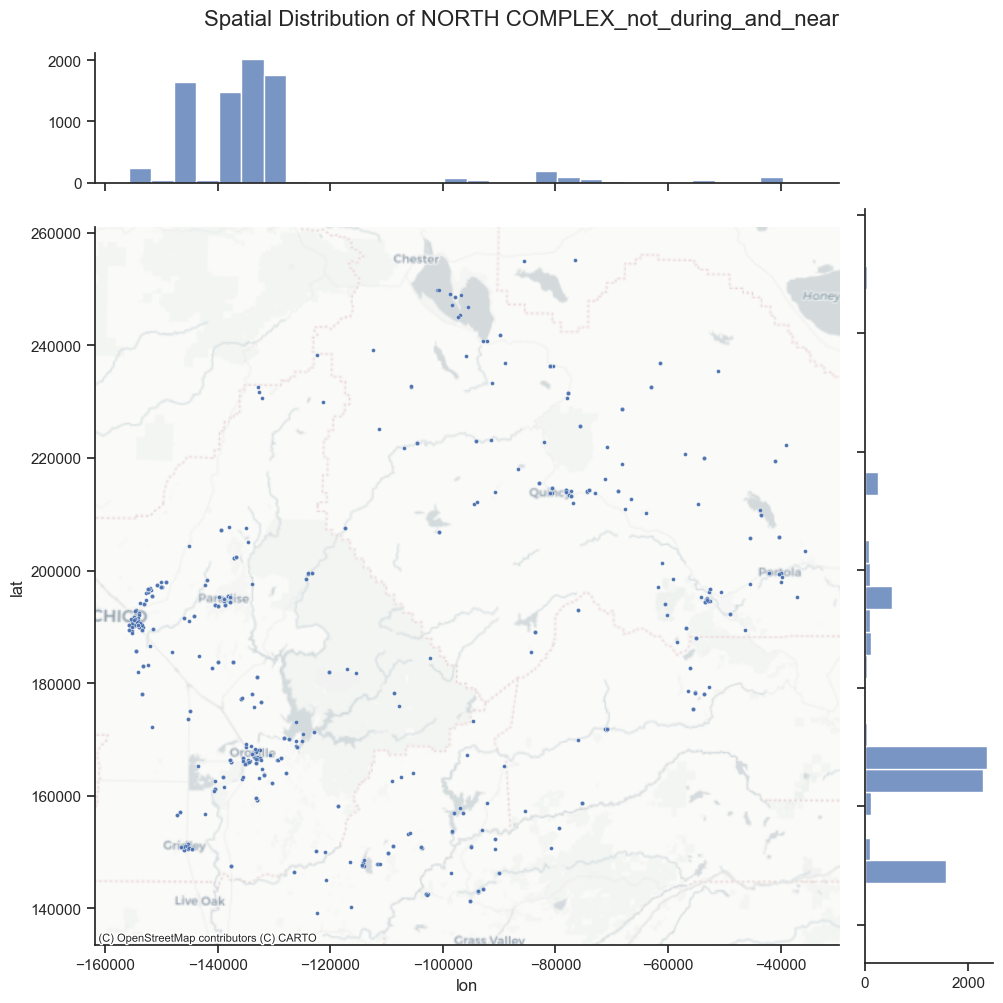

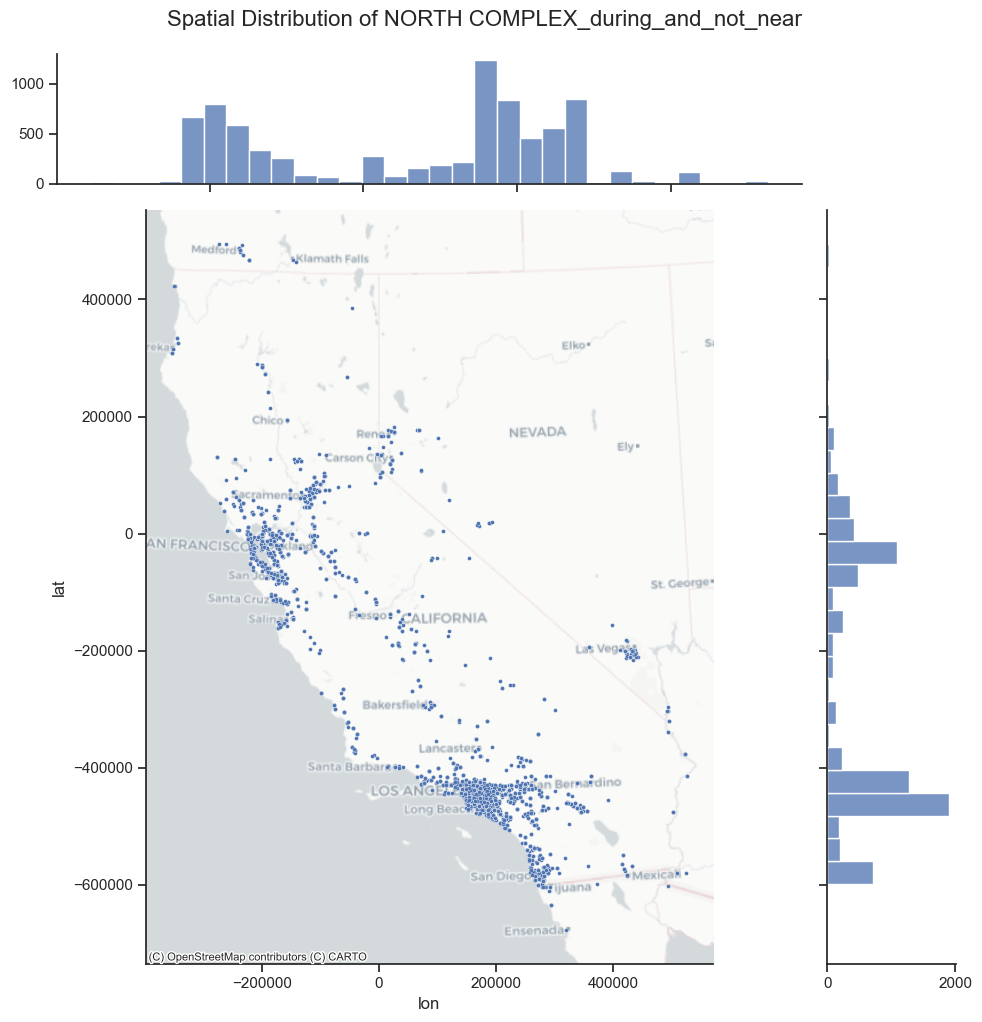

In [48]:
# save all 3 to geoJSON
for i in range(len(subsets)):
    subsets[i].to_file(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}.geojson', driver="GeoJSON")

        # Generate a jointplot with a base map to show spatial distribution
    joint_axes = sns.jointplot(
        x=subsets[i]["lon"], # specify the longitude column of the dataset
        y=subsets[i]["lat"], # specify the latitude column of the dataset
        data=subsets[i], # specify the dataset to be plotted
        s=8,
        height=10, # Increased height for a larger plot
        ratio=5,  # ratio controls size of the bar charts on top and right
        marginal_ticks=True, # specify the size of the point markers (in numeric terms, e.g. 3)
        marginal_kws=dict(bins=30) # Increase the number of bins
    )

    # formatter = FuncFormatter(millions)
    # joint_axes.ax_marg_x.xaxis.set_major_formatter(formatter)
    # joint_axes.ax_marg_y.yaxis.set_major_formatter(formatter)

    contextily.add_basemap(
        joint_axes.ax_joint, # join the basemap with the plot
        crs='EPSG:3310', # specify the coordinate reference system (should be the same as your data)
        source=contextily.providers.CartoDB.Positron # the style of the base map (but you can change it if you like)
    )

    plt.suptitle(f"Spatial Distribution of {names[i]}", fontsize=16, y=1.02)
    plt.savefig(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/spatial_distribution_{names[i]}.png', dpi=300, bbox_inches='tight')
    plt.show()




### Run ABEA On the Subsets

In [285]:
# re-load if saved geojson versions of the subsets already exist
subsets = []
#               0               1           2-           3           4-           5-         6-       7-          8-                 9-
fire_names = ['SCU COMPLEX', 'BOBCAT', 'HENNESSEY', 'DOLAN', 'NORTH COMPLEX', 'CASTLE', 'CREEK', 'SLATER', 'AUGUST COMPLEX', 'RED SALMON COMPLEX']
# which fire to create subsets and analyses for
specific_fire_name = fire_names[1]
print(specific_fire_name)

names = [f'{specific_fire_name}_during_and_near', f'{specific_fire_name}_not_during_and_near', f'{specific_fire_name}_during_and_not_near']

for i in range(len(names)):
    # read 
    subsets.append(gpd.read_file(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}.geojson'))
    print(f"added {names[i]} to the subsets list. Length: {len(subsets[i])}")



BOBCAT


09/22/2024 22:24:58 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/22/2024 22:25:00 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:25:01 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:25:02 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:25:24 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:25:26 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:25:27 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:25:40 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


added BOBCAT_during_and_near to the subsets list. Length: 735886


09/22/2024 22:26:59 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:27:02 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:27:04 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:27:07 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:27:09 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


added BOBCAT_not_during_and_near to the subsets list. Length: 735886


09/22/2024 22:27:30 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:27:54 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:27:55 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:28:05 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:28:09 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/22/2024 22:28:23 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/22/2024 22:28:32 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


added BOBCAT_during_and_not_near to the subsets list. Length: 735886


In [286]:
# for the abea dfs 
abea_subsets = []
abea_aspect_subsets = []

In [287]:
print(names[0])

BOBCAT_during_and_near


In [ ]:
# Your device settings (e.g. your laptop, PC, or cloud-based infrastructure)
device = "cuda"                                                 # else "cpu"
n_gpu = 1                                                       # nr. of GPUs being used

# The model file
# model_path = 'GRACE/data/same_split_as_absa/out_abea_w_denseClassifier_ateacs/pytorch_model.bin.11'
model_path = 'GRACE/data/same_split_as_absa/out_no_vat1_ateacs/pytorch_model.bin.17'
# model_path = 'GRACE/data/same_split_as_absa/out_orig_Hyperparams_w_ABEA_clean_ateacs/pytorch_model.bin.3'


# The Data you want to analyse
# data_path = "Data/Case Study Data/tweets_california_2020.tsv"   # Adjust this to your own data path! 
is_csv = False                                                  # If False, assumes this is a TSV file! 
use_subset = False                                              # Do you want to use a smaller random sample of your dataset? (e.g. for testing)
sample_size = 1000                                              # The size of your random sample (must be smaller than overall dataset size)
use_chunks = True                                               # whether or not to split the dataset into smaller chunks
chunk_size = 2000000

In [289]:
# set arguments required for model initialization
args = argparse.Namespace(
    data_dir='GRACE/data/same_split_as_absa/', 
    bert_model='bert-base-uncased',
    init_model=None,
    task_name="ate_asc",
    data_name="abea",
    train_file='nouns_w_none_train.txt',
    valid_file='nouns_w_none_trial.txt',
    test_file='nouns_w_none_test.gold.txt',
    output_dir='out_testing/',
    seed = 42,
    do_lower_case=True,
    local_rank=-1,
    eval_batch_size=32,
    max_seq_length=128,
    use_ghl=True, 
    use_vat=False, 
    use_decoder=True, 
    num_decoder_layer=2, 
    decoder_shared_layer=3)

random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

n_gpu = 1
data_name = args.data_name.lower()
task_name = args.task_name.lower()
task_config = {
    "use_ghl": True,
    "use_vat": False,
    "num_decoder_layer": 2,
    "decoder_shared_layer": 3,
}

In [290]:
# dataloader to preprocess the input data
def dataloader_val(args, tokenizer, file_path, label_tp_list, set_type="val"):

    dataset = ATEASCProcessor(file_path=file_path, set_type=set_type)
    print(f"\t- Loaded val file: {file_path}")

    eval_features = convert_examples_to_features(dataset.examples, label_tp_list,
                                                 args.max_seq_length, tokenizer, verbose_logging=False)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_at_label_ids = torch.tensor([f.at_label_id for f in eval_features], dtype=torch.long)
    all_as_label_ids = torch.tensor([f.as_label_id for f in eval_features], dtype=torch.long)

    all_label_mask = torch.tensor([f.label_mask for f in eval_features], dtype=torch.long)
    all_label_mask_X = torch.tensor([f.label_mask_X for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_at_label_ids, all_as_label_ids,
                              all_label_mask, all_label_mask_X)

    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    return eval_dataloader, eval_data

# function to initialise the model using the model file (the .bin file), the correct labels, and settings
def load_model(model_file, args, num_tp_labels, task_config, device):
    model_file = model_file
    if os.path.exists(model_file):
        model_state_dict = torch.load(model_file, map_location='cpu')
        print(f"\t- Model loaded from {model_file}")
        model = BertForSequenceLabeling.from_pretrained(args.bert_model, cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
                                                        state_dict=model_state_dict, num_tp_labels=num_tp_labels,
                                                        task_config=task_config)
        model.to(device)
    else:
        model = None
    return model

In [291]:
# load bert tokenizer (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

09/22/2024 22:28:46 - INFO - tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\chris\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [292]:
file_path = os.path.join(args.data_dir, args.train_file)
print(f"Loading task specific labels from {file_path}")

# the ATEASCProcessor reads data and splits it into corpus and label list for ATE and ASC
dataset = ATEASCProcessor(file_path=file_path, set_type="train")
at_labels, as_labels = get_labels(dataset.label_tp_list)
label_tp_list = (at_labels, as_labels)

at_num_labels = len(label_tp_list[0])
as_num_labels = len(label_tp_list[1])
num_tp_labels = (at_num_labels, as_num_labels)

task_config["at_labels"] = label_tp_list[0]

at_label_list, as_label_list = label_tp_list
at_label_map = {i: label for i, label in enumerate(at_label_list)}
as_label_map = {i: label for i, label in enumerate(as_label_list)}

# print infos to double-check all is correct
print(f"ATE labels: {at_label_map}")
print(f"ASC labels: {as_label_map}")

Loading task specific labels from GRACE/data/same_split_as_absa/nouns_w_none_train.txt
ATE labels: {0: 'O', 1: 'B-AP', 2: 'I-AP'}
ASC labels: {0: 'O', 1: 'NONE', 2: 'FEAR', 3: 'SADNESS', 4: 'ANGER', 5: 'HAPPINESS'}


In [293]:
# an adapted ate_asc_modeling_local_bert_file.py is imported here, which loads the model from a folder in the repo ('GRACE/bert-base-uncased/bert-base-uncased.tar.gz')

model_file = model_path
model = load_model(model_file, args, num_tp_labels, task_config, device)

if hasattr(model, 'module'):
    print('has module')
    model = model.module

# set model to eval mode (turn off training features e.g. dropout)
model.eval()

	- Model loaded from GRACE/data/same_split_as_absa/out_no_vat1_ateacs/pytorch_model.bin.17
loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\chris\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
extracting archive file C:\Users\chris\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\chris\AppData\Local\Temp\tmp4_h8ta5m


09/22/2024 22:28:50 - INFO - decoder_module -   loading archive file c:\Users\chris\Documents\PLUS SharePoint\Universität Salzburg\AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer\1 - Code\ABEA Repo\GRACE\decoder-bert-base


BertForSequenceLabeling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
  

In [295]:
import unicodedata
import ast

def remove_non_english(text, pattern):
    # Normalize Unicode to NFKC (Normalization Form KC)
    text = unicodedata.normalize('NFKC', text)
    # Check if it contains non-English characters
    return not bool(re.search(pattern, text))

# Function to check for any non-printable or invisible characters
def is_invisible(text):
    # Remove leading/trailing whitespaces and invisible characters
    text = unicodedata.normalize('NFKC', text).strip()
    # Check if all characters are either control characters (category 'C'), whitespace, or non-visible
    return all(unicodedata.category(c) in ('Cf', 'Zs', 'Zl', 'Zp', 'Cc') for c in text)


def split_and_clean(text):
    # Split the text based on the pattern
    words = re.findall(split_pattern, text)
    
    # Remove unwanted characters based on the unwanted pattern
    cleaned_words = [word for word in words if not re.search(unwanted_pattern, word)]
    
    return cleaned_words

# Transform the 'aspect_emotions' column by reducing lists to a single lowercase word
def reduce_to_single_word(emotion_list):
    if emotion_list:
        # Take the first emotion and convert to lowercase, assuming all are the same based on the filter
        emotion = emotion_list[0].split()[0].lower()
        # Replace "happiness" with "joy"
        return emotion
    return None

# Define a function to check if all emotions in a list are the same
def is_uniform(emotion_list):
    if not emotion_list:
        return False
    # Normalize the emotion strings to lowercase and split by spaces to handle cases like "SADNESS SADNESS"
    normalized = [set(e.lower().split()) for e in emotion_list]
    # Check if all sets in the list are equal to the first one
    return all(e == normalized[0] for e in normalized)


def remove_duplicate_words(df, column_name):
    """
    Removes duplicate words from a column in a DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame to operate on.
        column_name (str): The name of the column to remove duplicates from.
    
    Returns:
        pandas.DataFrame: A new DataFrame with the specified column modified.
    """
    new_df = df.copy()  # create a copy of the original DataFrame to avoid modifying it directly
    
    # split the column into separate words using spaces as delimiters
    word_lists = new_df[column_name].str.split(' ')
    
    # check if each list contains more than one word and if the words are all the same
    for i, words in enumerate(word_lists):
        if words:
            if len(words) > 1 and all(word == words[0] for word in words):
                word_lists[i] = [words[0]]  # replace the list with a new list containing only one word
        else:
            word_lists[i] = "-"
        
    # join the lists back into strings and assign the modified column back to the DataFrame
    new_df[column_name] = word_lists.str.join(' ')
    
    return new_df

# Function to safely evaluate and filter rows
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None
    

def uniform_and_mixed_emotions(df):
    # Copy the DataFrame
    df_copy = df.copy()
    
    # Apply the is_uniform function to identify rows with uniform emotions
    df_copy['is_uniform'] = df_copy['aspect_emotions'].apply(safe_literal_eval)
    df_copy['is_uniform'] = df_copy['is_uniform'].apply(is_uniform)
    
    # For uniform rows, apply reduce_to_single_word
    df_copy['emotion'] = df_copy.apply(
        lambda row: reduce_to_single_word(row['aspect_emotions']) if row['is_uniform'] else 'mixed', axis=1
    )
    
    # Drop the helper column 'is_uniform'
    df_copy.drop(columns=['is_uniform'], inplace=True)
    
    return df_copy

# Preprocess the data to fit the GRACE Model format
for c in range(len(subsets)):
    
    time.sleep(500)

    df = subsets[c].copy()

    print(f"Starting with subset {c}")

    # ------------------------ PREPROCESSING ---------------------------

    len_df_before_preprocessing = len(df)

    # check for non English characters 
    non_english_patterns = [
        r'[\u0600-\u06FF]',  # Arabic
        r'[\u4E00-\u9FFF]',  # Chinese
        r'[\u3040-\u309F]',  # Japanese Hiragana
        r'[\u30A0-\u30FF]',  # Japanese Katakana
        r'[\u1100-\u11FF]',  # Hangul (Korean)
        r'[재오픈이후지옥을맛보았고가을겨울]',
        r'[\u0400-\u04FF]',  # Cyrillic (Russian, etc.)
        r'[\u0370-\u03FF]',  # Greek
        r'[şığİçöüŞĞÇÖÜ]',   # Turkish characters
        r'[\u0E00-\u0E7F]',  # Thai characters
        r'[\u0900-\u097F]'  # Devanagari characters (Hindi, Marathi, Nepali, etc.)
    ]
    combined_non_english_pattern = '|'.join(non_english_patterns)  
    
    # remove usernames 
    df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+', 'USER', x))

    # remove links
    df['text'] = df['text'].apply(lambda x: re.sub(r'https://\S*', '.', x))

    # remove non english texts
    df = df[df['text'].apply(lambda x: remove_non_english(x, combined_non_english_pattern))]

    # Ensure there's no 'NaN' text
    df = df.dropna(subset=['text'])

    # Drop rows where the 'text' column is empty or contains only whitespace after processing
    df['text'] = df['text'].str.strip()     # remove leading and trailing whitespaces
    df = df[df['text'] != '']               # keep rows where 'text' is not an empty string
    df = df[~df['text'].apply(is_invisible)]  # Remove rows with invisible characters

    # remove emoji modifiers (that are added when splitting the text), 
    # unicode tag characters (e.g., language tags), 
    # and invisible characters, e.g., zero-width-joiners, and invisible control characters
    unwanted_pattern = r'[\U0001F3FB-\U0001F3FF\u2640\u2642\u200D\uFE0F\u2066\u2067\u2068\u2069\u2063\u2060\U000E0000-\U000E007F]'

    # split pattern that identifies user mentions, hashtags, words, 
    # standalone @ or #, and any special characters or symbols
    split_pattern = r'(@\w+|#\w+|\w+|[@#]|[^\w\s])'

    # move original text into new column for later reference
    df['text_original'] = df['text']

    # apply splitting and cleaning --> this will ensure that the GRACE formatting results 
    # in predictable rows, which is important in order to keep the length of the dataset exactly the same 
    # as the input df, for later result joining
    df['text_split'] = df['text'].apply(split_and_clean)
    df['text'] = df['text_split'].apply(lambda x: ' '.join(x))
    
    # Ensure there's no 'NaN' text
    df = df.dropna(subset=['text'])

    # Drop rows where the 'text' column is empty or contains only whitespace after processing
    df['text'] = df['text'].str.strip()     # remove leading and trailing whitespaces
    df = df[df['text'] != '']               # keep rows where 'text' is not an empty string
    df = df[~df['text'].apply(is_invisible)]  # Remove rows with invisible characters

    len_df_after_preprocessing = len(df)


    # ------------------------ GRACE FORMATTING ---------------------------


    # text column to list
    text_list = list(df['text'].astype(str))

    # input format for GRACE model
    addition = ' - - O O O'
    convert_to_doc = []

    tweet_counter = 0
    # iteratively apply re-formatting and save to new list
    for tweet in text_list:
        words = tweet.split()
        words_with_addition = []
        for word in words:
            new_word = word + addition
            #print(new_word)
            words_with_addition.append(new_word)
        convert_to_doc.append(words_with_addition)
        tweet_counter += 1
    
    
    write_counter = 0
    # Save in the Case study folder
    path_to_reformatted_data = f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[c]}_reformatted.txt'
    with open(path_to_reformatted_data, mode = "w", encoding='utf-8') as f:
        f.write("-DOCSTART-\n\n")
        for tweet in convert_to_doc:
            for word in tweet:
                f.write("%s\n" % word)
            f.write("\n")
            write_counter += 1

    # check how many sentences in reformatted.txt
    sentences = []
    current_sentence = []

    # Open the file and read line by line
    with open(path_to_reformatted_data, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespaces

            # Skip the -DOCSTART- line
            if line == "-DOCSTART-":
                continue

            # Check if it's an empty line (indicating the end of a sentence)
            if line == "":
                if current_sentence:
                    # Add the current sentence to the list of sentences and reset
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                # Add the non-empty line to the current sentence
                current_sentence.append(line)

        # Handle the last sentence (in case the file does not end with an empty line)
        if current_sentence:
            sentences.append(current_sentence)

    
    concatenated_list = [' '.join([word.split()[0] for word in sublist]) for sublist in convert_to_doc]
    df_sentences_right = pd.DataFrame(concatenated_list)

    if (len_df_after_preprocessing == 
        tweet_counter == write_counter == len(sentences)):
        print(f"\t- Good news, all variables have the same value: {len_df_after_preprocessing}" +
              f"\n\t- FYI the preprocessing removed {len_df_before_preprocessing - len_df_after_preprocessing} rows.")
    else:
        print(f"\t- WARNING! The variables do not all have the same value:\n" +
            f"\n\t- original df length: {len_df_before_preprocessing}"+
            f"\n\t- df length after preprocessing: {len_df_after_preprocessing}"+
            f"\n\t- nr tweets added to the textlist: {tweet_counter}"+
            f"\n\t- nr of tweets written to .txt file: {write_counter}"+
            f"\n\t- double check length when reading the sentences in .txt file: {len(sentences)}\n")
    

    # ------------------------ GRACE INFERENCES ---------------------------
    
    DATALOADER_DICT = {}
    # only "eval" state is needed ("train" is left out)
    DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}
    # Create dataloader with the prepared dataset
    eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")


    print(f'\t- Created dataloader. Now running ABEA...')

    # empty lists for both the identified aspect terms and the related emotions
    pred_aspect_terms = []
    pred_aspect_emotions = []
    
    counter = 0

    # for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
    # for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        at_label_ids = at_label_ids.to(device)
        as_label_ids = as_label_ids.to(device)
        label_mask = label_mask.to(device)
        label_mask_X = label_mask_X.to(device)
        
        with torch.no_grad():
            # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
            logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
            pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
            decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
            logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
            decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
            logits = logits.detach().cpu().numpy()
            decoder_logits = decoder_logits.detach().cpu().numpy()
            
        at_label_ids = at_label_ids.to('cpu').numpy()
        as_label_ids = as_label_ids.to('cpu').numpy()
        label_mask = label_mask.to('cpu').numpy()
        

        for i, mask_i in enumerate(label_mask):
            ate_labels = []
            aec_labels = []
            for j, l in enumerate(mask_i):
                if l > -1:
                    ate_labels.append(at_label_map[logits[i][j]])
                    aec_labels.append(as_label_map[decoder_logits[i][j]])
                    
            pred_aspect_terms.append(ate_labels)
            pred_aspect_emotions.append(aec_labels)

            counter += 1
    
    print(f"\t- Size of texts that were analysed: {counter}")

    print(f"\t- pred_aspect_terms: {len(pred_aspect_terms)}, pred_aspect_emotions: {len(pred_aspect_emotions)}, length of DataFrame: {len(df)}")

    df['aspect_term_preds'] = pred_aspect_terms
    df['aspect_emo_preds'] = pred_aspect_emotions

    print('\t- ABEA done. Now going to extract aspect terms and emotions...')


    # ------------------------ EXTRACT ASPECT TERMS AND EMOTIONS ---------------------------


    # Next step, extract the aspect term and emotion
    aspect_terms = []
    aspect_sentiments = []

    # for every row (tweet)
    for idx, row in df.iterrows():
        
        row_aspect_terms = []
        row_aspect_sentiments = []

        # split text into individual words
        words = row['text'].split()

        # Loop through aspect_term_preds
        for i, pred in enumerate(row['aspect_term_preds']):
            if pred == 'B-AP':
                # Initialize term with the current word
                term = words[i] if i < len(words) else ''
                sent = row['aspect_emo_preds'][i]

                # check for continuation of aspect term ('I-AP')
                j = i + 1
                while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                    # Append word to term if within bounds
                    if j < len(words):
                        term += ' ' + words[j]
                        sent += ' ' + row['aspect_emo_preds'][j]
                    j += 1

                # save the aspect term and emotion
                if term:  # Only add non-empty terms
                    row_aspect_terms.append(term)
                    row_aspect_sentiments.append(sent)

        # append extracted terms and sentiments to respective lists
        aspect_terms.append(row_aspect_terms)
        aspect_sentiments.append(row_aspect_sentiments)

    # assign the lists back to the DataFrame
    df['aspect_terms'] = aspect_terms
    df['aspect_emotions'] = aspect_sentiments

    # remove the previous columns
    df.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

    for col in df.columns:
        if isinstance(df[col].iloc[0], list):
            df[col] = df[col].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else x)

    

    df.to_file(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[c]}_abea.geojson', driver="GeoJSON")
    print("\t- ATE and AEC extraction done. File saved as geoJSON.\n")

    df['aspect_terms'] = df['aspect_terms'].apply(lambda x: x.split(','))
    df['aspect_emotions'] = df['aspect_emotions'].apply(lambda x: x.split(','))
    # df['aspect_emotions'] = df['aspect_emotions'].apply(safe_literal_eval)
    # df['aspect_terms'] = df['aspect_terms'].apply(safe_literal_eval)
    # create a list of dictionaries, where each dictionary corresponds to one item in the aspect_terms and aspect_sentiments lists
    rows = []
    for i, row in df.iterrows():
        if row['aspect_terms'] != None:
            if len(row['aspect_terms']) == len(row['aspect_emotions']):
                for j in range(len(row['aspect_terms'])):
                    # print(row['aspect_terms'][j])
                    # print(row['aspect_emotions'][j])
                    rows.append({
                        'message_id': row['message_id'],
                        'date': row['date'],
                        'text': row['text'],
                        'geom_type': row['geom_type'],
                        'lat': row['lat'],
                        'lon': row['lon'],
                        'geometry': row['geometry'],
                        'text_original': row['text_original'],
                        'text_split':row['text_split'],
                        'aspect_terms': row['aspect_terms'][j],
                        'aspect_emotions': row['aspect_emotions'][j]
                    })
                else:
                    rows.append({
                        'message_id': row['message_id'],
                        'date': row['date'],
                        'text': row['text'],
                        'geom_type': row['geom_type'],
                        'lat': row['lat'],
                        'lon': row['lon'],
                        'geometry': row['geometry'],
                        'text_original': row['text_original'],
                        'text_split':row['text_split'],
                        'aspect_terms': '-',
                        'aspect_emotions': '-'
                    })
        else:
            rows.append({
                'message_id': row['message_id'],
                'date': row['date'],
                'text': row['text'],
                'geom_type': row['geom_type'],
                'lat': row['lat'],
                'lon': row['lon'],
                'geometry': row['geometry'],
                'text_original': row['text_original'],
                'text_split':row['text_split'],
                'aspect_terms': row['aspect_terms'],
                'aspect_emotions': row['aspect_emotions']
            })

    # create a new DataFrame from the list of dictionaries
    new_df = gpd.GeoDataFrame(rows, geometry='geometry', crs="EPSG:3310")
    aspect_df = remove_duplicate_words(new_df, 'aspect_emotions')
    aspect_df.to_file(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[c]}_abea_singleEmo.geojson', driver="GeoJSON")


    abea_subsets.append(df)
    abea_aspect_subsets.append(aspect_df)

Starting with subset 0
	- Good news, all variables have the same value: 728705
	- FYI the preprocessing removed 7181 rows.
	- Loaded val file: Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_during_and_near_reformatted.txt
	- Created dataloader. Now running ABEA...


Evaluating: 100%|██████████| 22773/22773 [53:21<00:00,  7.11it/s]   


	- Size of texts that were analysed: 728705
	- pred_aspect_terms: 728705, pred_aspect_emotions: 728705, length of DataFrame: 728705
	- ABEA done. Now going to extract aspect terms and emotions...
	- ATE and AEC extraction done. File saved as geoJSON.

Starting with subset 1
	- Good news, all variables have the same value: 726503
	- FYI the preprocessing removed 9383 rows.
	- Loaded val file: Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_not_during_and_near_reformatted.txt
	- Created dataloader. Now running ABEA...


Evaluating: 100%|██████████| 22704/22704 [53:20<00:00,  7.09it/s]   


	- Size of texts that were analysed: 726503
	- pred_aspect_terms: 726503, pred_aspect_emotions: 726503, length of DataFrame: 726503
	- ABEA done. Now going to extract aspect terms and emotions...
	- ATE and AEC extraction done. File saved as geoJSON.

Starting with subset 2
	- Good news, all variables have the same value: 728292
	- FYI the preprocessing removed 7594 rows.
	- Loaded val file: Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_during_and_not_near_reformatted.txt
	- Created dataloader. Now running ABEA...


Evaluating: 100%|██████████| 22760/22760 [53:27<00:00,  7.10it/s]  


	- Size of texts that were analysed: 728292
	- pred_aspect_terms: 728292, pred_aspect_emotions: 728292, length of DataFrame: 728292
	- ABEA done. Now going to extract aspect terms and emotions...
	- ATE and AEC extraction done. File saved as geoJSON.



In [280]:
df.head(3)

,Unnamed: 0,message_id,date,text,geom_type,lat,lon,geometry,text_original,text_split,aspect_terms,aspect_emotions
0,13619197,1302857855733624832,2020-09-07 06:34:53,Wtf . . . is this ? Golleee 🥴 🥴 🥴,Polygon,-459904.705004,148318.791033,POINT (148318.791 -459904.705),Wtf... is this? Golleee 🥴🥴🥴,"Wtf,.,.,.,is,this,?,Golleee,🥴,🥴,🥴","[this, Golleee]","[FEAR, ANGER]"
1,16946694,1307789924033155072,2020-09-20 21:13:10,USER Lol can ’ t even be surprised at this point,Polygon,-449976.153887,152872.400110,POINT (152872.400 -449976.154),USER Lol can’t even be surprised at this point,"USER,Lol,can,’,t,even,be,surprised,at,this,point",[USER],[SADNESS]
2,16657150,1295035942919532545,2020-08-16 16:33:24,USER “ I understand how ski jumping works ” “ ...,Polygon,8280.404559,-188476.113085,POINT (-188476.113 8280.405),USER “I understand how ski jumping works”\n“I ...,"USER,“,I,understand,how,ski,jumping,works,”,“,...","[ski jumping, You, jumping, skiing, ski jumpin...","[SADNESS SADNESS, SADNESS, SADNESS, SADNESS, N..."


In [281]:
aspect_df.head(3)

,message_id,date,text,geom_type,lat,lon,geometry,text_original,text_split,aspect_terms,aspect_emotions
0,1302857855733624832,2020-09-07 06:34:53,Wtf . . . is this ? Golleee 🥴 🥴 🥴,Polygon,-459904.705004,148318.791033,POINT (148318.791 -459904.705),Wtf... is this? Golleee 🥴🥴🥴,"Wtf,.,.,.,is,this,?,Golleee,🥴,🥴,🥴",this,FEAR
1,1302857855733624832,2020-09-07 06:34:53,Wtf . . . is this ? Golleee 🥴 🥴 🥴,Polygon,-459904.705004,148318.791033,POINT (148318.791 -459904.705),Wtf... is this? Golleee 🥴🥴🥴,"Wtf,.,.,.,is,this,?,Golleee,🥴,🥴,🥴",Golleee,ANGER
2,1302857855733624832,2020-09-07 06:34:53,Wtf . . . is this ? Golleee 🥴 🥴 🥴,Polygon,-459904.705004,148318.791033,POINT (148318.791 -459904.705),Wtf... is this? Golleee 🥴🥴🥴,"Wtf,.,.,.,is,this,?,Golleee,🥴,🥴,🥴",-,-


## Stats on Emotions and Aspect Terms per Fire

- doughnut piechart showing the emotion distribution per fire
- the top non-stopword aspect terms per emotion per fire

In [282]:
import ast

# Function to safely evaluate and filter rows
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

In [283]:
print(len(subsets))
print(names[1])
abea_aspect_subsets[0].sample(3)

3
SCU COMPLEX_not_during_and_near


,message_id,date,text,geom_type,lat,lon,geometry,text_original,text_split,aspect_terms,aspect_emotions
461740,1306732000892469249,2020-09-17 23:09:21,i hate washing dishes,Polygon,-31614.212387,-126414.346705,POINT (-126414.347 -31614.212),i hate washing dishes,"i,hate,washing,dishes",-,-
649744,1297614911283945472,2020-08-23 19:21:18,10 / 10,Polygon,-52948.740789,-174693.346093,POINT (-174693.346 -52948.741),10/10,"10,/,10",,
717962,1295510755458969601,2020-08-18 00:00:08,Love how the A / C decides to break this week ...,Polygon,-57100.772208,-76142.621786,POINT (-76142.622 -57100.772),Love how the A/C decides to break this week of...,"Love,how,the,A,/,C,decides,to,break,this,week,...",A / C,ANGER


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing subset: SCU COMPLEX_during_and_near


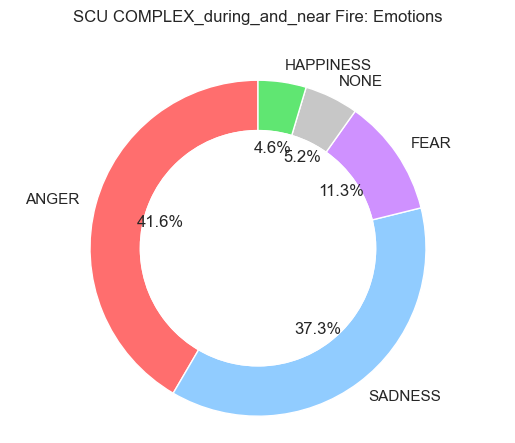

unique emotions: ['ANGER', 'SADNESS', 'NONE', 'FEAR', 'HAPPINESS']
['money', 'god', 'bill ” album', 'torture porn', 'toni collette', 'this one', '4v4', 'white people', 'white lady', 'poc well being']
['savings', 'drink', 'office', 'healing', 'fake “ illnesses', 'americans', 'brandy', 'shit', 'time', 'hawaii']
['girls', 'ill bills', 'ilk', 'endorsement', 'local pigs', 'type', 'friend', 'offices', 'pop culture', 'rangers']
['cup', 'track', 'type', 'job', 'job', 'restaurants', 'argument', 'mum', 'player', 'contracts']
['leslie ’', 'service job openings', '#healthwelfare job', 'oligos', 'kelly', '#qa job', 'opening', 'user reds', 'event', 'civil war']
Processing subset: SCU COMPLEX_not_during_and_near


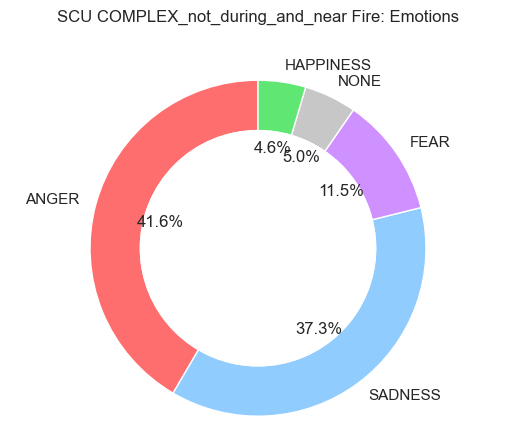

unique emotions: ['SADNESS', 'ANGER', 'FEAR', 'HAPPINESS', 'NONE']
['smoke', 'virgil', 'brick', 'podcast', 'feet', 'crack', 'trailer', 'job', 'data analyst', 'wireless customer services']
['twilight robert pattinson', 'daily stoic ”', 'dermatologist', 'sloth', 'leopard print', 'user user nerd minors', 'drinking', 'dudes', 'albert', 'weekend']
['luna', 'vs', 'culture', '2 mins', 'face', 'flights', 'thing', 'work environment', 'position', 'mundo']
['california skin institute', '…', 'user legend', 'public discourse', 'country', 'election', 'bottas', 'mission city center for performing arts', 'mazda mx - 30', '#spanoscurse']
['leopard', 'piece', 'keywords', 'picks', 'canada', 'ladies', 'cvscareers team', 'everything', 'meme', 'oracle container engine']
Processing subset: SCU COMPLEX_during_and_not_near


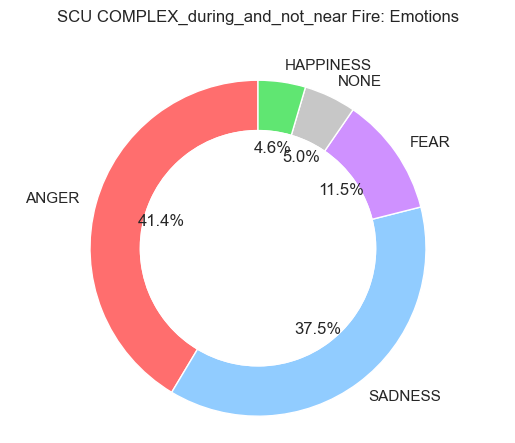

unique emotions: ['FEAR', 'ANGER', 'SADNESS', 'NONE', 'HAPPINESS']
['mi', 'mi', 'food', 'people', 'phone', 'user automation', 'user someone', 'everyone', 'big w', 'tent']
['golleee', 'user user regal', 'beverly pils', 'monster of a pc', 'ps4', 'weeknd', 'twerps', 'tucker', 'stand up nigga', 'caruso']
['ski jumping', 'jumping', 'skiing', 'effect', 'movie', 'beer', 'bread', 'amor', 'año', 'oral hygiene']
['ski jumping', '2018', 'digs', 'rep conventions', 'bats', 'officers', 'jersey', 'cutie', 'balm', 'you all']
['skiing', 'political science analyses', 'gente', 'politics', 'nba', 'schools', 'schools', 'weight estimate', '15 minutes', 'dancer shoes']


In [ ]:
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

abea_result_subsets = []

def get_top_words_by_emotion(df, emotion, top_n=20):

    stop_words = nltk.corpus.stopwords.words('english')
    new_stop_words = ['user', 'user user', 'user user user', 'user user user user', 'link', 'photo']
    stop_words.extend(new_stop_words)
    emotion_df = df[df['aspect_emotions'] == emotion]

    # print(emotion_df[:5])
    
    all_words = []
    
    for _, row in emotion_df.iterrows():
        term = row['aspect_terms']
        # if term.isalpha() and term.lower() not in stop_words:
        if term.lower() not in stop_words:
            # print("true")
            all_words.append(term.lower())
        # else:
            # print(term)
    print(all_words[:10])
        
    word_counts = Counter(all_words)
    return word_counts  # Return the Counter object itself



# Function to filter out shared words and get the top N words
def filter_and_get_top_words(word_counts, shared_words, top_n=20):
    filtered_word_counts = {word: count for word, count in word_counts.items() if word not in shared_words}
    return Counter(filtered_word_counts).most_common(top_n)

def get_top_words(word_counts, top_n=20):
    return Counter(word_counts).most_common(top_n)

def group_terms(row):
    grouped_terms = []
    current_group = []
    for term in row['aspect_terms']:
        if ' '.join(current_group + [term]) in row['text']:
            current_group.append(term)
        else:
            if current_group:
                grouped_terms.append(' '.join(current_group))
            current_group = [term]
    if current_group:
        grouped_terms.append(' '.join(current_group))
    return grouped_terms


def handle_emotions(row):
    # Clean and split the emotions by commas or spaces
    emotions = re.split(r'[,\s]+', row['aspect_emotions'].strip())
    emotions = [e for e in emotions if e]  # Remove empty strings
    
    if len(set(emotions)) == 1:
        return pd.Series([row['grouped_terms'], emotions[0]])
    else:
        return pd.Series([[row['grouped_terms']] * len(emotions), emotions])

def group_terms(row):
    grouped_terms = []
    current_group = []
    for term in row['aspect_terms']:
        if ' '.join(current_group + [term]) in row['text']:
            current_group.append(term)
        else:
            if current_group:
                grouped_terms.append(' '.join(current_group))
            current_group = [term]
    if current_group:
        grouped_terms.append(' '.join(current_group))
    return grouped_terms

for i in range(len(abea_aspect_subsets)):

    print(f"Processing subset: {names[i]}")
    
    df = abea_aspect_subsets[i].copy()
    # print(f"Initial number of rows: {len(df)}")

    # Step 1: Remove any rows that have empty strings in the 'aspect_terms' and 'aspect_emotions' columns
    df = df[df['aspect_emotions']!= "-"]
    df = df[df['aspect_emotions']!= ""]
    df = df[df['aspect_emotions']!= "O"]

    # --- EMOTIONS --- 

    emotion_counts = df['aspect_emotions'].value_counts()

    # print(emotion_counts)

    color_mapping = {
        'HAPPINESS': '#60e672',  # green
        'FEAR': '#cf91ff',       # purple
        'SADNESS': '#91ccff',    # Blue
        'ANGER': '#ff6e6e',      # Red
        'NONE': '#c7c7c7',      # grey
        'O': '#c9c9c9'
    }

    # list of colors based on emotion labels
    colors = [color_mapping[label] for label in emotion_counts.index if label != '']

    fig, ax = plt.subplots()
    ax.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.3}, colors=colors)
    ax.axis('equal')

    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    plt.title(f'{names[i]} Fire: Emotions', pad=30)

    # Save the figure as a PNG file
    plt.savefig(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}_fire_emotions.png', dpi=300, bbox_inches='tight')

    plt.show()

    # doughnut-style pie chart
    fig, ax = plt.subplots()
    ax.pie(emotion_counts, labels=None, autopct=None, startangle=90, wedgeprops={'width': 0.3}, colors=colors)

    ax.axis('equal')

    # center circle for the doughnut look
    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    plt.savefig(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}_fire_emo_no_lab.png', dpi=300, bbox_inches='tight')

    plt.close(fig)

    
    # --- MOST FREQUENT AT PER EMOTION ---

    excluded_emotions = ['', 'O']
    emotions = [emotion for emotion in df['aspect_emotions'].dropna().unique() if emotion not in excluded_emotions]
    print(f"unique emotions: {emotions}")

    # dict to store word counts for each emotion
    word_counts_by_emotion = {}

    for emotion in emotions:
        word_counts_by_emotion[emotion] = get_top_words_by_emotion(df, emotion) # TODO FIND ERROR HERE 

    # print(f"word_counts_by_emotion: {word_counts_by_emotion}")

    # words that are shared by all emotions
    shared_words = set.intersection(*[set(word_counts.keys()) for word_counts in word_counts_by_emotion.values()])


    # dict to store the filtered top words for each emotion
    filtered_top_words_by_emotion_shared_removed = {}
    filtered_top_words_by_emotion = {}

    for emotion, word_counts in word_counts_by_emotion.items():
        # print(f"key and value in word_counts_by_emotion dict: {emotion}, {word_counts}")
        filtered_top_words_by_emotion_shared_removed[emotion] = filter_and_get_top_words(word_counts, shared_words)
        filtered_top_words_by_emotion[emotion] = get_top_words(word_counts)

    # save results to a text file
    with open(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}_top_words_by_emotion_shared_r.txt', 'w') as f:
        for emotion, words in filtered_top_words_by_emotion_shared_removed.items():
            # print(f"emotion and words in filtered_top_words_by_emotion_shared_removed: {emotion}, {words}")
            f.write(f"{emotion.capitalize()}:\n")
            
            # Loop through the top 5 words
            for word, count in words:
                f.write(f"  {word}: {count}\n")
            
            f.write("\n")

    with open(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}_top_words_by_emotion.txt', 'w') as f:
        for emotion, words in filtered_top_words_by_emotion.items():
            f.write(f"{emotion.capitalize()}:\n")
            
            # Loop through the top 5 words
            for word, count in words:
                f.write(f"  {word}: {count}\n")
            
            f.write("\n")



## Re-Load GeoJSON Files to just get Stats

hennessey_during = "C:\Users\chris\Documents\PLUS SharePoint\Universität Salzburg\AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer\1 - Code\ABEA Repo\Data\Case Study Data\Stats Per Fire\HENNESSEY\HENNESSEY_during_and_not_near_abea_singleEmo.geojson"

In [27]:
# hennessey_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/HENNESSEY_during_and_near_abea_singleEmo.geojson"
# hennessey_not_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/HENNESSEY_not_during_and_near_abea_singleEmo.geojson"
# scu_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/SCU COMPLEX/SCU COMPLEX_during_and_near_abea_singleEmo.geojson"
# scu_not_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/SCU COMPLEX/SCU COMPLEX_not_during_and_near_abea_singleEmo.geojson"


# paths= [hennessey_during, hennessey_not_during, scu_during, scu_not_during]
# analyse_dfs = []
# names = ['hennessey_during', 'hennessey_not_during', 'scu_during', 'scu_not_during']

# dolan_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/DOLAN/DOLAN_during_and_near_abea_singleEmo.geojson"
# dolan_not_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/DOLAN/DOLAN_not_during_and_near_abea_singleEmo.geojson"
# bobcat_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_during_and_near_abea_singleEmo.geojson"
# bobcat_not_during = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_not_during_and_near_abea_singleEmo.geojson"

# paths= [dolan_during, dolan_not_during, bobcat_during, bobcat_not_during]
# analyse_dfs = []
# names = ['dolan_during', 'dolan_not_during', 'bobcat_during', 'bobcat_not_during']


dolan_not_near = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/DOLAN/DOLAN_during_and_not_near_abea_singleEmo.geojson"
bobcat_not_near = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_during_and_not_near_abea_singleEmo.geojson"
scu_not_near = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/SCU COMPLEX/SCU COMPLEX_during_and_not_near_abea_singleEmo.geojson"
hennessey_not_near = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/HENNESSEY_during_and_not_near_abea_singleEmo.geojson"

paths= [dolan_not_near, bobcat_not_near, scu_not_near, hennessey_not_near]
analyse_dfs = []
names = ['dolan_not_near', 'bobcat_not_near', 'scu_not_near', 'hennessey_not_near']


for i in range(len(paths)):

    gdf = gpd.read_file(paths[i])
    print(names[i])
    print(len(gdf))
    analyse_dfs.append(gdf)



filter_terms_fire = ['fire', 'smoke', 'forest', 'inferno', 'blaze', 'hot', 'disaster', 'destruction', 'wind', 'lightning', 'storm']
fire_pattern = '|'.join(filter_terms_fire)
fire_gdfs = []

filter_terms_responders = ['police', 'cop', 'responder', 'firefighter', 'fighter', 'dept', 'department', 'sheriff', 'deputy', 'volunteer']
responders_pattern = '|'.join(filter_terms_responders)
responders_gdfs = []

for i in range(len(analyse_dfs)):

    gdf = analyse_dfs[i].copy()
    print(names[i])

    fire_gdf = gdf[gdf['aspect_terms'].str.contains(fire_pattern, case=False, na=False)]
    print(f"len(fire_gdf): {len(fire_gdf)}")
    fire_gdfs.append(fire_gdf)

    responders_gdf = gdf[gdf['aspect_terms'].str.contains(responders_pattern, case=False, na=False)]
    print(f"len(responders_gdf): {len(responders_gdf)}")
    responders_gdfs.append(responders_gdf)





dolan_not_near
52729


09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/30/2024 12:28:29 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


bobcat_not_near
2131167


09/30/2024 12:32:41 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/30/2024 12:32:41 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:32:41 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:32:41 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/30/2024 12:32:41 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:32:41 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
09/30/2024 12:32:51 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
09/30/2024 12:32:51 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


scu_not_near
1111461
hennessey_not_near
311710
dolan_not_near
len(fire_gdf): 510
len(responders_gdf): 74
bobcat_not_near
len(fire_gdf): 21117
len(responders_gdf): 3016
scu_not_near
len(fire_gdf): 9735
len(responders_gdf): 2310
hennessey_not_near
len(fire_gdf): 2862
len(responders_gdf): 595


In [22]:
check = responders_gdfs[0]
check.sample(2)

,message_id,date,text,geom_type,lat,lon,text_original,text_split,aspect_terms,aspect_emotions,geometry
25165,1306341145832689665,2020-09-16 21:16:14,And my co worker thought it was her dad but op...,Polygon,-187430.467532,-111514.676938,And my co worker thought it was her dad but op...,"And,my,co,worker,thought,it,was,her,dad,but,op...",cops,ANGER,POINT (-111514.677 -187430.468)
27869,1297195904856801280,2020-08-22 15:36:19,Me and my brother don ’ t mess around . Trying...,Polygon,-199562.900622,-101489.240699,Me and my brother don’t mess around. Trying ou...,"Me,and,my,brother,don,’,t,mess,around,.,Trying...",scopes,ANGER,POINT (-101489.241 -199562.901)


In [ ]:
import ast

# Function to safely evaluate and filter rows
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

In [ ]:
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

abea_result_subsets = []

def get_top_words_by_emotion(df, emotion, top_n=20):

    stop_words = nltk.corpus.stopwords.words('english')
    new_stop_words = ['user', 'user user', 'user user user', 'user user user user', 'link', 'photo']
    stop_words.extend(new_stop_words)
    emotion_df = df[df['aspect_emotions'] == emotion]

    # print(emotion_df[:5])
    
    all_words = []
    
    for _, row in emotion_df.iterrows():
        term = row['aspect_terms']
        # if term.isalpha() and term.lower() not in stop_words:
        if term.lower() not in stop_words:
            # print("true")
            all_words.append(term.lower())
        # else:
            # print(term)
    print(all_words[:10])
        
    word_counts = Counter(all_words)
    return word_counts  # Return the Counter object itself


# Function to filter out shared words and get the top N words
def filter_and_get_top_words(word_counts, shared_words, top_n=20):
    filtered_word_counts = {word: count for word, count in word_counts.items() if word not in shared_words}
    return Counter(filtered_word_counts).most_common(top_n)


def get_top_words(word_counts, top_n=20):
    return Counter(word_counts).most_common(top_n)


def handle_emotions(row):
    # Clean and split the emotions by commas or spaces
    emotions = re.split(r'[,\s]+', row['aspect_emotions'].strip())
    emotions = [e for e in emotions if e]  # Remove empty strings
    
    if len(set(emotions)) == 1:
        return pd.Series([row['grouped_terms'], emotions[0]])
    else:
        return pd.Series([[row['grouped_terms']] * len(emotions), emotions])


def group_terms(row):
    grouped_terms = []
    current_group = []
    for term in row['aspect_terms']:
        if ' '.join(current_group + [term]) in row['text']:
            current_group.append(term)
        else:
            if current_group:
                grouped_terms.append(' '.join(current_group))
            current_group = [term]
    if current_group:
        grouped_terms.append(' '.join(current_group))
    return grouped_terms

for i in range(len(fire_gdfs)):

    print(f"Processing subset: {names[i]}")
    df = fire_gdfs[i].copy()


    # --- EMOTIONS --- 

    emotion_counts = df['aspect_emotions'].value_counts()

    # print(emotion_counts)

    color_mapping = {
        'HAPPINESS': '#60e672',  # green
        'FEAR': '#cf91ff',       # purple
        'SADNESS': '#91ccff',    # Blue
        'ANGER': '#ff6e6e',      # Red
        'NONE': '#c7c7c7',      # grey
        'O': '#c9c9c9'
    }

    # list of colors based on emotion labels
    colors = [color_mapping[label] for label in emotion_counts.index if label != '']

    fig, ax = plt.subplots()
    ax.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.3}, colors=colors)

    ax.axis('equal')

    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    plt.title(f'{names[i]}: Emotions', pad=30)
    plt.show()

    fig, ax = plt.subplots()
    ax.pie(emotion_counts, labels=None, autopct=None, startangle=90, wedgeprops={'width': 0.3}, colors=colors)

    ax.axis('equal')

    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    # No plt.show() for the second plot to avoid displaying it
    # plt.close(fig)

    
    # --- MOST FREQUENT AT PER EMOTION ---

    # Get unique emotions in the aspect_emo column
    excluded_emotions = ['', 'O']
    emotions = [emotion for emotion in df['aspect_emotions'].dropna().unique() if emotion not in excluded_emotions]
    print(f"unique emotions: {emotions}")

    # Create a dictionary to store word counts for each emotion
    word_counts_by_emotion = {}

    # Loop through each emotion and get the word counts
    for emotion in emotions:
        word_counts_by_emotion[emotion] = get_top_words_by_emotion(df, emotion) # TODO FIND ERROR HERE 

    # Create a dictionary to store the filtered top words for each emotion
    filtered_top_words_by_emotion = {}

    for emotion, word_counts in word_counts_by_emotion.items():
        filtered_top_words_by_emotion[emotion] = get_top_words(word_counts)

    with open(f'C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/top_words_filtered_subsets/{names[i]}_fire_top_words_by_emotion.txt', 'w') as f:
        for emotion, words in filtered_top_words_by_emotion.items():
            f.write(f"{emotion.capitalize()}:\n")
            
            # Loop through the top 5 words
            for word, count in words:
                f.write(f"  {word}: {count}\n")
            
            f.write("\n")



## Timelines

In [2]:
scu_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/SCU COMPLEX/SCU COMPLEX_during_and_near_abea_singleEmo.geojson"
scu_near = gpd.read_file(scu_near_path)

scu_not_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/SCU COMPLEX/SCU COMPLEX_during_and_not_near_abea_singleEmo.geojson"
scu_not_near = gpd.read_file(scu_not_near_path)

hennessey_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/HENNESSEY_during_and_near_abea_singleEmo.geojson"
hennessey_near = gpd.read_file(hennessey_near_path)

hennessey_not_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/HENNESSEY_during_and_not_near_abea_singleEmo.geojson"
hennessey_not_near = gpd.read_file(hennessey_not_near_path)

dolan_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/DOLAN/DOLAN_during_and_near_abea_singleEmo.geojson"
dolan_near = gpd.read_file(dolan_near_path)

dolan_not_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/DOLAN/DOLAN_during_and_not_near_abea_singleEmo.geojson"
dolan_not_near = gpd.read_file(dolan_not_near_path)

bobcat_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_during_and_near_abea_singleEmo.geojson"
bobcat_near = gpd.read_file(bobcat_near_path)

bobcat_not_near_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/BOBCAT/BOBCAT_during_and_not_near_abea_singleEmo.geojson"
bobcat_not_near = gpd.read_file(bobcat_not_near_path)



10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
10/02/2024 15:05:21 - WARNING - fiona.ogrext -   Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


In [7]:
pairs = [[scu_near, scu_not_near], [hennessey_near, hennessey_not_near], [dolan_near, dolan_not_near], [bobcat_near, bobcat_not_near]]
pair_names = ['SCU Complex', 'Hennessey', 'Dolan', 'Bobcat']

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


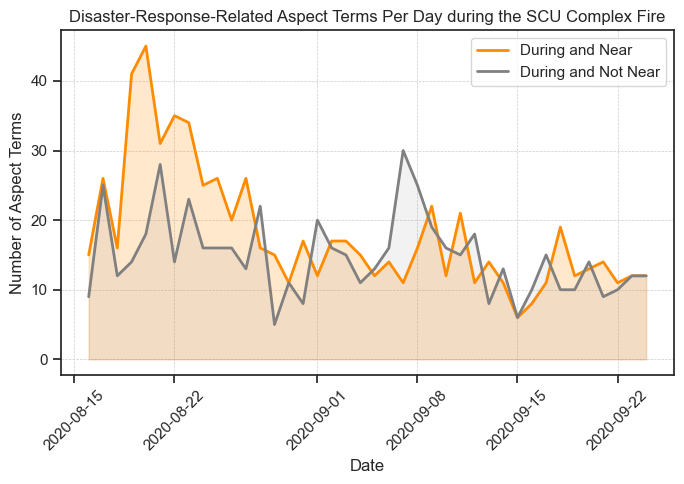

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


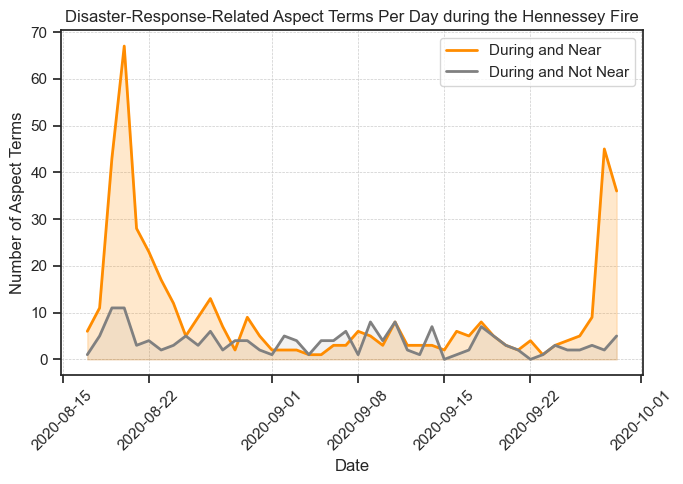

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


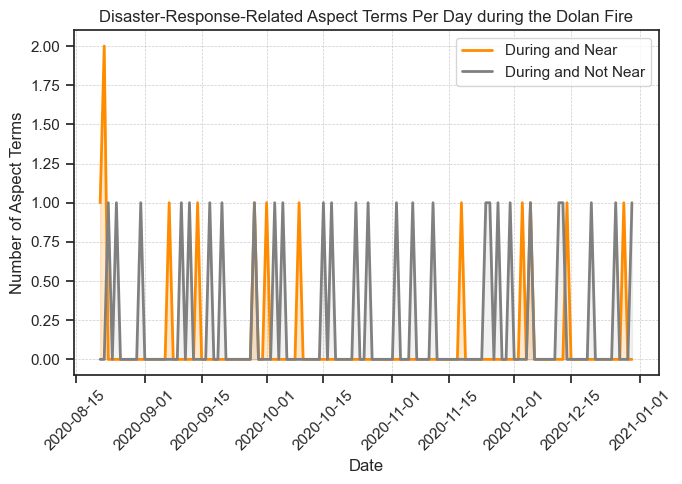

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


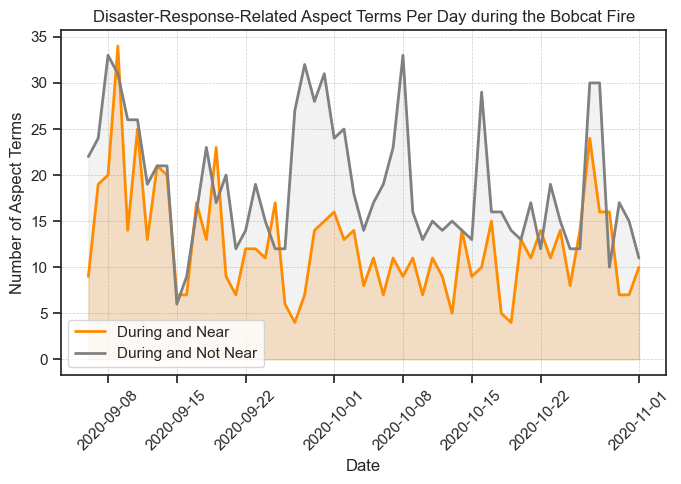

In [ ]:
# filter = ['fire', 'smoke', 'forest']
# fire_filter = ['fire', 'smoke', 'forest', 'inferno', 'blaze', 'disaster', 'destruction', 'wind', 'lightning', 'storm', 'emergency',' wildfire', 'evacuation', 'hazard','burn', 'drought', 'ash', 'flame']
# filter = ['responder', 'firefight', 'heli', 'rescue']
filter = ['help', 'evacuation', 'rescue', 'response', 'respond']

pattern = '|'.join(filter)


for i in range(len(pairs)): 

    gdf0 = pairs[i][0]
    gdf1 = pairs[i][1]

    gdf0 = gdf0[gdf0['aspect_terms'].str.contains(pattern, case=False, na=False)]
    gdf1 = gdf1[gdf1['aspect_terms'].str.contains(pattern, case=False, na=False)]


    # convert the 'date' column to datetime if it is not already
    gdf0['date'] = pd.to_datetime(gdf0['date'])
    gdf1['date'] = pd.to_datetime(gdf1['date'])

    # extract the date part (without time) for both GeoDataFrames
    gdf0['date'] = gdf0['date'].dt.date
    gdf1['date'] = gdf1['date'].dt.date

    # Group by date and count the occurrences per day
    gdf0_counts = gdf0.groupby('date').size()
    gdf1_counts = gdf1.groupby('date').size()

    # Create a complete date range from the minimum to the maximum date across both GeoDataFrames
    date_range = pd.date_range(start=min(gdf0['date'].min(), gdf1['date'].min()),
                            end=max(gdf0['date'].max(), gdf1['date'].max()))

    # Reindex both series to include all dates within the range, filling missing dates with 0
    gdf0_counts = gdf0_counts.reindex(date_range, fill_value=0)
    gdf1_counts = gdf1_counts.reindex(date_range, fill_value=0)

    plt.figure(figsize=(7, 5))

    plt.plot(gdf0_counts.index, gdf0_counts.values, label='During and Near', color='darkorange', linestyle='-', linewidth=2)
    plt.plot(gdf1_counts.index, gdf1_counts.values, label='During and Not Near', color='grey', linestyle='-', linewidth=2)

    # transparent fills under the lines
    plt.fill_between(gdf0_counts.index, gdf0_counts.values, color='darkorange', alpha=0.2)
    plt.fill_between(gdf1_counts.index, gdf1_counts.values, color='grey', alpha=0.1)

    plt.xlabel('Date')
    plt.ylabel('Number of Aspect Terms')
    plt.title(f'Disaster-Response-Related Aspect Terms Per Day during the {pair_names[i]} Fire')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

In [4]:
gdf.sample(2)

,message_id,date,text,geom_type,lat,lon,text_original,text_split,aspect_terms,aspect_emotions,geometry
713566,1300575503959560192,2020-08-31 23:25:38,i guess i ’ m gonna be the weird ass bird lady...,Polygon,166294.845453,14849.614708,i guess i’m gonna be the weird ass bird lady n...,"i,guess,i,’,m,gonna,be,the,weird,ass,bird,lady...",bird lady,SADNESS,POINT (14849.615 166294.845)
318330,1308449241073819648,2020-09-22 16:53:03,USER missing you everyday makes my heart feel ...,Polygon,-296204.787198,88521.259418,USER missing you everyday makes my heart feel ...,"USER,missing,you,everyday,makes,my,heart,feel,...",-,-,POINT (88521.259 -296204.787)


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


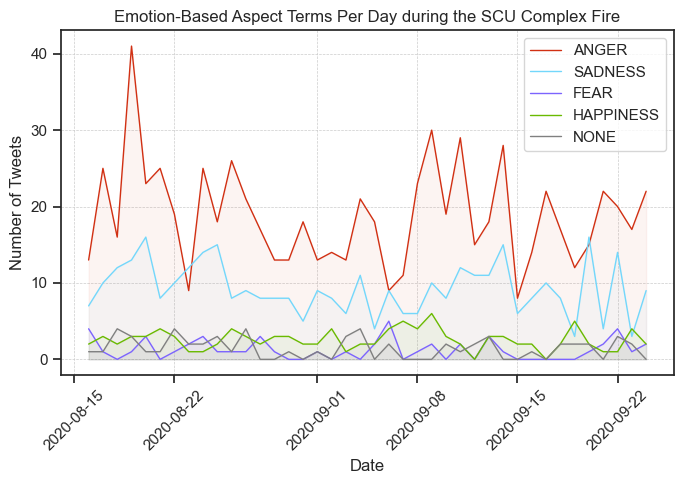

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


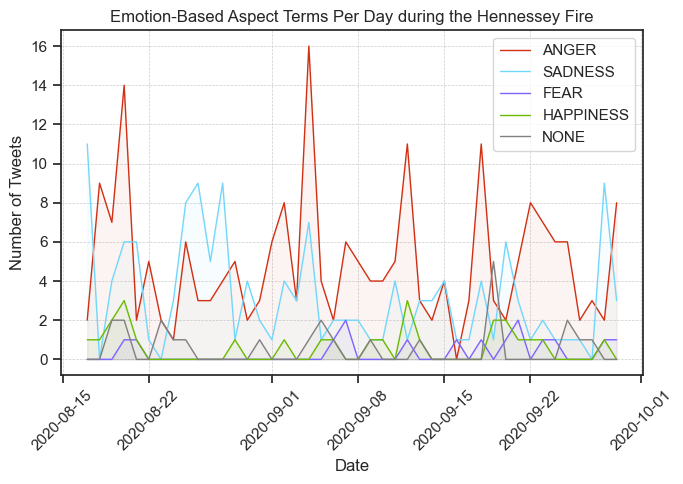

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


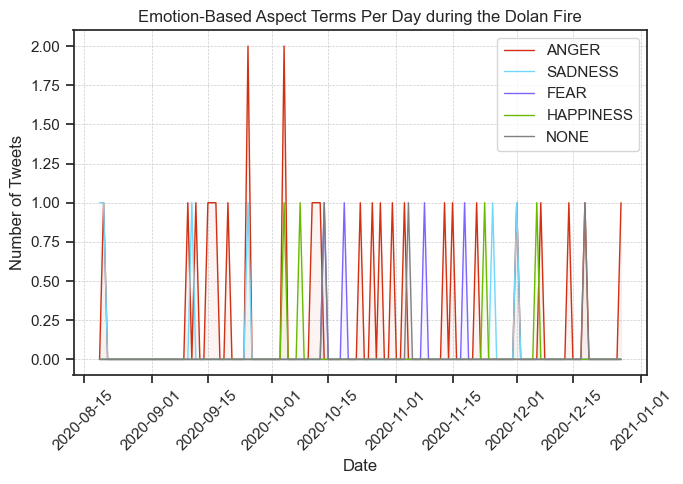

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


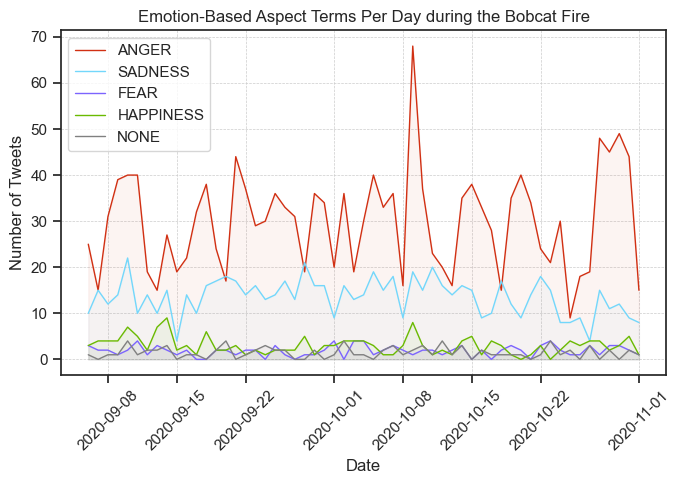

In [ ]:
# filter = ['fire', 'smoke', 'forest']
# filter = ['fire', 'smoke', 'forest', 'inferno', 'blaze', 'disaster', 'destruction', 'wind', 'lightning', 'storm', 'emergency',' wildfire', 'evacuation', 'hazard','burn', 'drought', 'ash', 'flame']
# fire_filter = ['responder', 'firefight', 'heli', 'rescue']
# fire_filter = ['help', 'evacuation', 'rescue', 'response', 'respond', 'relief', 'crisis', 'displace', 'coordinat', 'recover', 'shelter']
# fire_filter = ['family', 'brother', 'sister', 'parents', 'mother', 'father', 'grandparents', 'community', 'neighbor']
# fire_filter = ['fire']
# fire_filter = ['smoke', 'burn', 'flame', 'fire', 'wind', 'lightning']
fire_filter = ['road', 'street', 'access', 'block', 'traffic']


pattern = '|'.join(fire_filter)

for i in range(len(pairs)): 
    gdf0 = pairs[i][0]

    # filter based on aspect terms
    gdf0 = gdf0[gdf0['aspect_terms'].str.contains(pattern, case=False, na=False)]

    # convert date column to datetime if it is not already
    gdf0['date'] = pd.to_datetime(gdf0['date'])

    gdf0['date'] = gdf0['date'].dt.date

    # group by date and aspect_emotions and count occurrences per day per emotion
    gdf0_counts = gdf0.groupby(['date', 'aspect_emotions']).size().unstack(fill_value=0)

    # Create a complete date range from the minimum to the maximum date
    date_range = pd.date_range(start=gdf0['date'].min(), end=gdf0['date'].max())

    # reindex to include all dates within the range, filling missing dates with 0
    gdf0_counts = gdf0_counts.reindex(date_range, fill_value=0)

    plt.figure(figsize=(7, 5))

    emotions = ['ANGER', 'SADNESS', 'FEAR', 'HAPPINESS', 'NONE']
    colors = ['#D13013', '#73D7FB', '#7C64FE', '#6ABA01', 'grey']

    for emotion, color in zip(emotions, colors):
        # line chart
        plt.plot(gdf0_counts.index, gdf0_counts[emotion], label=emotion, color=color, linestyle='-', linewidth=1)

        # transparent fills under the line
        plt.fill_between(gdf0_counts.index, gdf0_counts[emotion], color=color, alpha=0.05)

    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')
    plt.title(f'Emotion-Based Aspect Terms Per Day during the {pair_names[i]} Fire')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()


## Vacaville

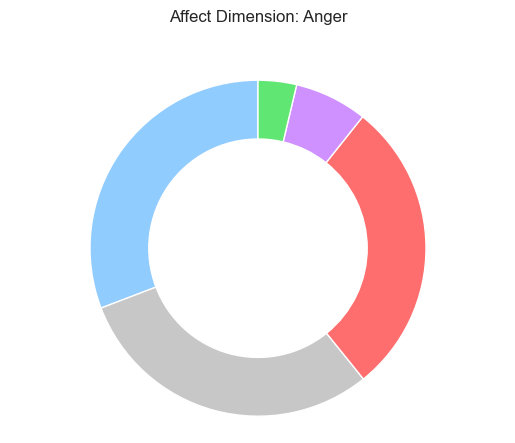

In [ ]:
# create piechart with emotion distribution

# Count the occurrences of each emotion in the 'aspect_emo' column
# emotion_counts = [5.1, 58.9, 10.3, 2.8, 22.6]
# labels = ['HAPPINESS', 'FEAR', 'SADNESS', 'ANGER', 'NONE']
# colors = ['#60e672', '#cf91ff', '#91ccff', '#ff6e6e', '#c7c7c7']

emotion_counts = [30.8, 30.0, 28.5, 7.0, 3.7]
labels = ['SADNESS', 'NONE', 'ANGER', 'FEAR', 'HAPPINESS']
colors = ['#91ccff', '#c7c7c7', '#ff6e6e', '#cf91ff', '#60e672']

fig, ax = plt.subplots()
ax.pie(emotion_counts, startangle=90, wedgeprops={'width': 0.35}, colors=colors)

# equal aspect ratio
ax.axis('equal')

# center circle for doughnut look
center_circle = plt.Circle((0, 0), 0.40, fc='white')
fig.gca().add_artist(center_circle)

plt.title(f'Affect Dimension: Anger', pad=30)

# plt.savefig(f'Data/Case Study Data/Stats Per Fire/{specific_fire_name}/{names[i]}_fire_emotions.png', dpi=300, bbox_inches='tight')

plt.show()


In [2]:
vacaville_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/vacaville_during_near.shp"
vacaville = gpd.read_file(vacaville_path)

napa_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/napa_during_near.shp"
napa = gpd.read_file(napa_path)

fairfield_path = "C:/Users/chris/Documents/PLUS SharePoint/Universität Salzburg/AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer/1 - Code/ABEA Repo/Data/Case Study Data/Stats Per Fire/HENNESSEY/fairfield_during_near.shp"
fairfield = gpd.read_file(fairfield_path)

10/05/2024 20:57:46 - WARNING - fiona.ogrext -   Failed to decode b'Additionally, the mother always getting their way & the husband giving in to that behavior, teaches the daughter(s) that all men must be that way w them (also toxic) and teaches the son(s) that they need a woman who is always \xe2\x80\x9cright,\xe2\x80\x9d even when she\xef\xbf' using utf-8 codec
10/05/2024 20:57:46 - WARNING - fiona.ogrext -   Failed to decode b'Additionally, the mother always getting their way & the husband giving in to that behavior, teaches the daughter(s) that all men must be that way w them (also toxic) and teaches the son(s) that they need a woman who is always \xe2\x80\x9cright,\xe2\x80\x9d even when she\xef\xbf' using utf-8 codec
10/05/2024 20:57:46 - WARNING - fiona.ogrext -   Failed to decode b'Additionally, the mother always getting their way & the husband giving in to that behavior, teaches the daughter(s) that all men must be that way w them (also toxic) and teaches the son(s) that they n

In [3]:
print(len(vacaville))
print(len(napa))
print(len(fairfield))

towns = [vacaville, napa, fairfield]
names = ['Vacaville', 'Napa', 'Fairfield']

38711
30686
40092


In [ ]:
pd.set_option('display.max_colwidth', None)
vacaville.sample(10)

,message_id,date,text,geom_type,lat,lon,text_origi,text_split,aspect_ter,aspect_emo,geometry
2606,1.300927e+18,2020/09/01 22:41:05.000,Black history is part of US history . . . ?,Polygon,40306.11395,-172082.804156,Black history is part of US history...?,"Black,history,is,part,of,US,history,.,.,.,?",Black history,HAPPINESS,POINT (-172082.804 40306.114)
12831,1.305640e+18,2020/09/14 22:49:44.000,USER Wild part calling it the Kong Flu isn ' t funny anymore but could be according to Trump Supporters now that ' s funny,Polygon,40306.11395,-172082.804156,USER Wild part calling it the Kong Flu isn't funny anymore but could be according to Trump Supporters now that's funny,"USER,Wild,part,calling,it,the,Kong,Flu,isn,',t,funny,anymore,but,could,be,according,to,Trump,Supporters,now,that,',s,funny",USER Wild part,SADNESS,POINT (-172082.804 40306.114)
9231,1.304256e+18,2020/09/11 03:12:24.000,"Wake up sleepyheads ! When somebody follows you follow back right away b4 you forget . I pay $ . 99 a month to a Twitter service & it gives me all of the data I nerd : the people that I need to fb here ’ s the people that haven ’ t followed you , unf",Polygon,40306.11395,-172082.804156,"Wake up sleepyheads! When somebody follows you follow back right away b4 you forget. I pay $.99 a month to a Twitter service & it gives me all of the data I nerd: the people that I need to fb here’s the people that haven’t followed you, unfollows et","Wake,up,sleepyheads,!,When,somebody,follows,you,follow,back,right,away,b4,you,forget,.,I,pay,$,.,99,a,month,to,a,Twitter,service,&,it,gives,me,all,of,the,data,I,nerd,:,the,people,that,I,need,to,fb,here,’,s,the,people,that,haven,’,t,followed,you,,,unf",data,SADNESS,POINT (-172082.804 40306.114)
35459,1.299250e+18,2020/08/28 07:36:44.000,USER Stay Marvelous Tamika,Polygon,40306.11395,-172082.804156,USER Stay Marvelous Tamika,"USER,Stay,Marvelous,Tamika",USER,ANGER,POINT (-172082.804 40306.114)
16163,1.307179e+18,2020/09/19 04:46:02.000,"Just gonna put “ hi , welcome to Chili ’ s ” on my resume",Polygon,40306.11395,-172082.804156,"Just gonna put “hi, welcome to Chili’s” on my resume","Just,gonna,put,“,hi,,,welcome,to,Chili,’,s,”,on,my,resume",-,-,POINT (-172082.804 40306.114)
33443,1.298608e+18,2020/08/26 13:08:12.000,Me asf with my bf & vice versa 😂 💀,Polygon,40306.11395,-172082.804156,Me asf with my bf & vice versa 😂💀,"Me,asf,with,my,bf,&,vice,versa,😂,💀",Me,SADNESS,POINT (-172082.804 40306.114)
2244,1.300828e+18,2020/09/01 16:09:44.000,i ’ m so ready for halloween,Polygon,40306.11395,-172082.804156,i’m so ready for halloween,"i,’,m,so,ready,for,halloween",halloween,ANGER,POINT (-172082.804 40306.114)
7537,1.303318e+18,2020/09/08 13:01:39.000,I guess it ’ s a new thing to floss some1 else ’ s shit #bozo might as well borrow the niggaz shoes too,Polygon,40306.11395,-172082.804156,I guess it’s a new thing to floss some1 else’s shit #bozo might as well borrow the niggaz shoes too,"I,guess,it,’,s,a,new,thing,to,floss,some1,else,’,s,shit,#bozo,might,as,well,borrow,the,niggaz,shoes,too",-,-,POINT (-172082.804 40306.114)
25516,1.308616e+18,2020/09/23 03:55:50.000,this is my entire brand,Polygon,40306.11395,-172082.804156,this is my entire brand,"this,is,my,entire,brand",brand,FEAR,POINT (-172082.804 40306.114)
19879,1.309673e+18,2020/09/26 01:54:32.000,Unreal ! ! ! ! 😡,Polygon,40306.11395,-172082.804156,Unreal!!!!😡,"Unreal,!,!,!,!,😡",None,None,POINT (-172082.804 40306.114)


In [ ]:
# SEARCH TERMS

# filter = ['smoke', 'wind']
# filter = ['fire', 'smoke', 'burn']
# filter = ['fire', 'smoke', 'forest', 'inferno', 'blaze', 'disaster', 'destruction', 'wind', 'lightning', 'storm', 'emergency',' wildfire', 'evacuation', 'hazard','burn', 'drought', 'ash', 'flame']
# filter = ['responder', 'firefight', 'heli', 'rescue']
filter = ['help', 'evacuation', 'rescue', 'response', 'respond', 'relief', 'crisis', 'displace', 'coordinat', 'recover', 'shelter']
# filter = ['family', 'brother', 'sister', 'parents', 'mother', 'father', 'grandparents', 'community', 'neighbor']
# filter = ['shelter' ,'help', 'support', 'safety']
# filter = ['smoke', 'burn', 'flame', 'fire', 'wind', 'lightning']
# filter = ['road', 'street', 'access', 'block', 'traffic']
# filter = ['evac', 'rescue', 'relief']

pattern = '|'.join(filter)

for i in range(len(towns)):
    if i ==1: 
        gdf_copy = towns[i].copy()
        gdf_copy = gdf_copy[gdf_copy['aspect_ter'].str.contains(pattern, case=False, na=False)]
        print(len(gdf_copy))

    
pd.set_option('display.max_colwidth', None)
gdf_copy.sample(10)


105


,message_id,date,text,geom_type,lat,lon,text_origi,text_split,aspect_ter,aspect_emo,geometry
22208,1.296264e+18,2020/08/20 01:53:51.000,#NAPA COUNTY OES : New evacuation order issued . . #HennesseyFire,Polygon,33654.496242,-201431.537912,#NAPA COUNTY OES: New evacuation order issued. . #HennesseyFire,"#NAPA,COUNTY,OES,:,New,evacuation,order,issued,.,.,#HennesseyFire",evacuation order,HAPPINESS,POINT (-201431.538 33654.496)
24049,1.296569e+18,2020/08/20 22:04:53.000,"#NAPA COUNTY OES : New Fire Evacuation Warnings West of HWY 29 . #LNULightningComplex This evacuation warning ( not an order as yet ) covers the Oakville Grade area including Niebaum , Manley and Bella Oaks lanes , and Beerstecher Road .",Polygon,33654.496242,-201431.537912,"#NAPA COUNTY OES: New Fire Evacuation Warnings West of HWY 29 . #LNULightningComplex \n\nThis evacuation warning (not an order as yet) covers the Oakville Grade area including Niebaum, Manley and Bella Oaks lanes, and Beerstecher Road.","#NAPA,COUNTY,OES,:,New,Fire,Evacuation,Warnings,West,of,HWY,29,.,#LNULightningComplex,This,evacuation,warning,(,not,an,order,as,yet,),covers,the,Oakville,Grade,area,including,Niebaum,,,Manley,and,Bella,Oaks,lanes,,,and,Beerstecher,Road,.",evacuation warning,HAPPINESS,POINT (-201431.538 33654.496)
22562,1.310588e+18,2020/09/28 14:32:48.000,An evacuation warning has been upgraded to an evacuation order for the east side of Silverado Trail between Taplin Road and Sage Canyon Road and Sage Canyon Road east to Chiles Pope Valley Road . #GlassFire #GlassIncident #NapaValley,Polygon,33654.496242,-201431.537912,An evacuation warning has been upgraded to an evacuation order for the east side of Silverado Trail between Taplin Road and Sage Canyon Road and Sage Canyon Road east to Chiles Pope Valley Road.\n\n#GlassFire #GlassIncident #NapaValley,"An,evacuation,warning,has,been,upgraded,to,an,evacuation,order,for,the,east,side,of,Silverado,Trail,between,Taplin,Road,and,Sage,Canyon,Road,and,Sage,Canyon,Road,east,to,Chiles,Pope,Valley,Road,.,#GlassFire,#GlassIncident,#NapaValley",evacuation warning,HAPPINESS,POINT (-201431.538 33654.496)
30324,1.300251e+18,2020/08/31 01:56:09.000,"USER USER USER USER USER USER USER USER No es preciso el primer puesto , pero el segundo si , estamos muy felices ! Ya respondí , ya puedes it por tu cheque paisa !",Polygon,33654.496242,-201431.537912,"USER USER USER USER USER USER USER USER No es preciso el primer puesto, pero el segundo si, estamos muy felices! \nYa respondí, ya puedes it por tu cheque paisa!","USER,USER,USER,USER,USER,USER,USER,USER,No,es,preciso,el,primer,puesto,,,pero,el,segundo,si,,,estamos,muy,felices,!,Ya,respondí,,,ya,puedes,it,por,tu,cheque,paisa,!",respondí,ANGER,POINT (-201431.538 33654.496)
28940,1.299436e+18,2020/08/28 19:58:27.000,"Mr . Rogers used to say "" in a crisis look to the helpers "" , USER today underlines the fact that he is not among them and all he wants to do is create more bureaucracy .",Polygon,33654.496242,-201431.537912,"Mr. Rogers used to say ""in a crisis look to the helpers"", USER today underlines the fact that he is not among them and all he wants to do is create more bureaucracy.","Mr,.,Rogers,used,to,say,"",in,a,crisis,look,to,the,helpers,"",,,USER,today,underlines,the,fact,that,he,is,not,among,them,and,all,he,wants,to,do,is,create,more,bureaucracy,.",helpers,ANGER,POINT (-201431.538 33654.496)
20177,1.310987e+18,2020/09/29 16:56:03.000,"Morning #GLASSINCIDENT update ( Napa Co ) : 42 , 000 acres 0 % contained 12 , 000 people evacuated Hot spots are north end of Silverado Trl near Calistoga and Bothe Park off Hwy 29 . Shelters at Crosswalk church and NVC , resources also there for mental",Polygon,33654.496242,-201431.537912,"Morning #GLASSINCIDENT update (Napa Co):\n42,000 acres\n0% contained\n12,000 people evacuated\nHot spots are north end of Silverado Trl near Calistoga and Bothe Park off Hwy 29.\nShelters at Crosswalk church and NVC, resources also there for mental health ser","Morning,#G

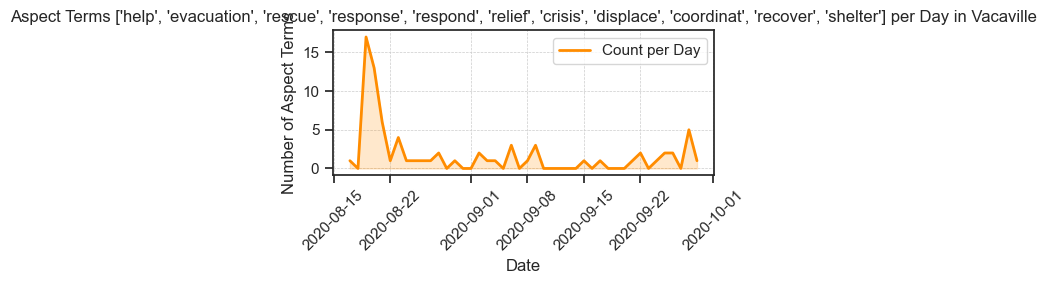

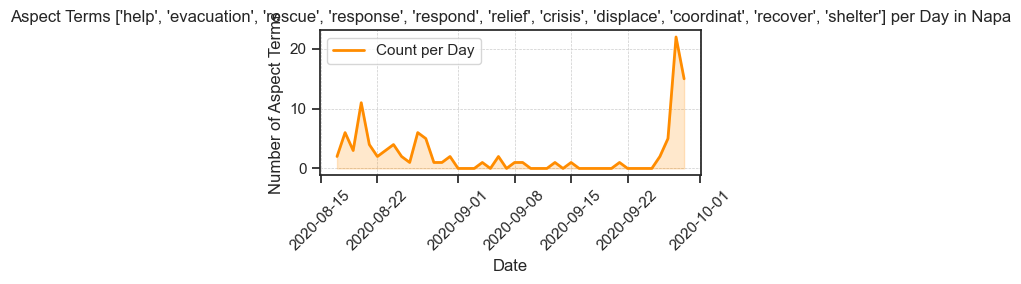

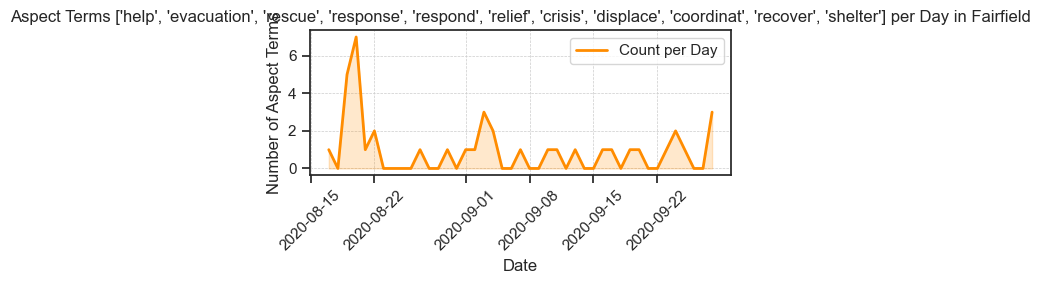

In [ ]:
for i in range(len(towns)):

    gdf_copy = towns[i].copy()
    gdf_copy = gdf_copy[gdf_copy['aspect_ter'].str.contains(pattern, case=False, na=False)]


    gdf_copy['date'] = pd.to_datetime(gdf_copy['date'])
    gdf_copy['date'] = gdf_copy['date'].dt.date 
    gdf0_counts = gdf_copy.groupby('date').size()

    date_range = pd.date_range(start=gdf_copy['date'].min(), end=gdf_copy['date'].max())    # create a complete date range from the minimum to the maximum date

    gdf0_counts = gdf0_counts.reindex(date_range, fill_value=0)    # reindex to include all dates within the range, filling missing dates with 0

    plt.figure(figsize=(5, 3))
    plt.plot(gdf0_counts.index, gdf0_counts.values, label='Count per Day', color='darkorange', linestyle='-', linewidth=2)

    # transparent fills under the lines
    plt.fill_between(gdf0_counts.index, gdf0_counts.values, color='darkorange', alpha=0.2)

    plt.xlabel('Date')
    plt.ylabel('Number of Aspect Terms')
    plt.title(f'Aspect Terms {filter} per Day in {names[i]}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

Vacaville
Napa
Fairfield


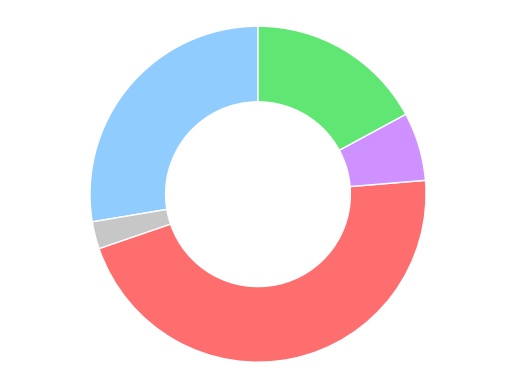

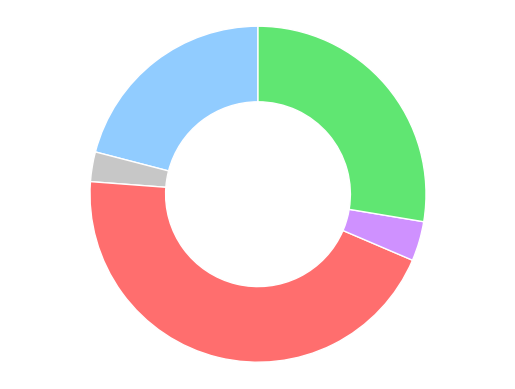

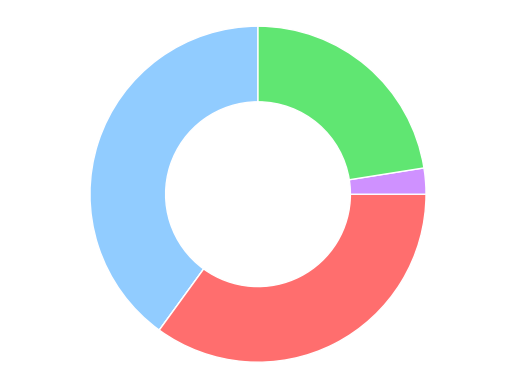

In [ ]:
for i in range(len(towns)):

    print(names[i])

    gdf_copy = towns[i].copy()
    gdf_copy = gdf_copy[gdf_copy['aspect_ter'].str.contains(pattern, case=False, na=False)]
        
    # convert the 'date' column to datetime
    gdf_copy['date'] = pd.to_datetime(gdf_copy['date'])

    #  extract the date part (without time)
    gdf_copy['date'] = gdf_copy['date'].dt.date

    # Group by aspect emotions and count occurrences
    emotion_counts = gdf_copy['aspect_emo'].value_counts()

    # labels and corresponding colors
    labels = ['SADNESS', 'NONE', 'ANGER', 'FEAR', 'HAPPINESS']
    colors = ['#91ccff', '#c7c7c7', '#ff6e6e', '#cf91ff', '#60e672']

    # Reorder emotion_counts to match the order of labels, filling missing labels with 0
    emotion_counts = emotion_counts.reindex(labels, fill_value=0)

    # # Create the pie chart
    # fig, ax = plt.subplots()
    # ax.pie(emotion_counts, startangle=90, wedgeprops={'width': 0.35}, colors=colors, labels=labels, autopct='%1.1f%%')

    # # Equal aspect ratio ensures that the pie is drawn as a circle.
    # ax.axis('equal')

    # # Add a center circle for the doughnut look
    # center_circle = plt.Circle((0, 0), 0.40, fc='white')
    # fig.gca().add_artist(center_circle)

    # # Show the plot
    # plt.show()

    fig, ax = plt.subplots()
    ax.pie(emotion_counts, startangle=90, wedgeprops={'width': 0.45}, colors=colors)

    ax.axis('equal')

    center_circle = plt.Circle((0, 0), 0.45, fc='white')
    fig.gca().add_artist(center_circle)



In [ ]:
abea_result_subsets = []

def get_top_words_by_emotion(df, emotion, top_n=20):

    stop_words = nltk.corpus.stopwords.words('english')
    new_stop_words = ['user', 'user user', 'user user user', 'user user user user', 'link', 'photo']
    stop_words.extend(new_stop_words)
    emotion_df = df[df['aspect_emo'] == emotion]

    # print(emotion_df[:5])
    
    all_words = []
    
    for _, row in emotion_df.iterrows():
        term = row['aspect_ter']
        # if term.isalpha() and term.lower() not in stop_words:
        if term.lower() not in stop_words:
            # print("true")
            all_words.append(term.lower())
        # else:
            # print(term)
    print(all_words[:10])
        
    word_counts = Counter(all_words)
    return word_counts  # Return the Counter object itself

def filter_and_get_top_words(word_counts, shared_words, top_n=20):
    filtered_word_counts = {word: count for word, count in word_counts.items() if word not in shared_words}
    return Counter(filtered_word_counts).most_common(top_n)

def get_top_words(word_counts, top_n=20):
    return Counter(word_counts).most_common(top_n)

def handle_emotions(row):
    emotions = re.split(r'[,\s]+', row['aspect_emo'].strip())
    emotions = [e for e in emotions if e]  # remove empty strings
    
    if len(set(emotions)) == 1:
        return pd.Series([row['grouped_terms'], emotions[0]])
    else:
        return pd.Series([[row['grouped_terms']] * len(emotions), emotions])

def group_terms(row):
    grouped_terms = []
    current_group = []
    for term in row['aspect_ter']:
        if ' '.join(current_group + [term]) in row['text']:
            current_group.append(term)
        else:
            if current_group:
                grouped_terms.append(' '.join(current_group))
            current_group = [term]
    if current_group:
        grouped_terms.append(' '.join(current_group))
    return grouped_terms

for i in range(len(towns)):

    print(f"Processing subset: {names[i]}")
    df = towns[i].copy()

    df = df[df['aspect_ter'].str.contains(pattern, case=False, na=False)]

    # --- MOST FREQUENT AT PER EMOTION ---

    # Get unique emotions in the aspect_emo column
    excluded_emotions = ['', 'O']
    emotions = [emotion for emotion in df['aspect_emo'].dropna().unique() if emotion not in excluded_emotions]
    print(f"unique emotions: {emotions}")

    # Create a dictionary to store word counts for each emotion
    word_counts_by_emotion = {}

    # Loop through each emotion and get the word counts
    for emotion in emotions:
        word_counts_by_emotion[emotion] = get_top_words_by_emotion(df, emotion) # TODO FIND ERROR HERE 

    # Create a dictionary to store the filtered top words for each emotion
    filtered_top_words_by_emotion = {}

    for emotion, word_counts in word_counts_by_emotion.items():
        filtered_top_words_by_emotion[emotion] = get_top_words(word_counts)
    for emotion, words in filtered_top_words_by_emotion.items():
        print(f"{emotion.capitalize()}:\n")
        
        # Loop through the top 5 words
        for word, count in words:
            print(f"  {word}: {count}")

Processing subset: Vacaville
unique emotions: ['ANGER', 'SADNESS', 'HAPPINESS', 'NONE', 'FEAR']
['#coronavirus response', 'flint water crisis', 'recovery rate', 'recovery', 'first responders', 'operation rescue', 'response', 'first responders', 'courage if first responders', 'evacuations']
['site services coordinator', 'crisis', 'coordinated style', 'response', 'evacuation jitters', 'recovery', 'covid 19 response', 'respond', 'response', 'helplessness']
['98 % recovery rate', 'health crisis', 'pc coordinator', 'fire evacuation warning', 'evacuation packs', 'evacuation orders', 'evacuation orders', 'evacuation orders', 'site services coordinator', 'evacuation order']
['response', 'site services coordinator']
['pc coordinator', 'evacuation areas', 'respond', 'respond', 'evacuation order']
Anger:

  first responders: 6
  evacuation orders: 3
  copy and paste response: 3
  evacuations: 2
  evacuation order: 2
  #coronavirus response: 1
  flint water crisis: 1
  recovery rate: 1
  recovery:

KeyError: 'NONE'

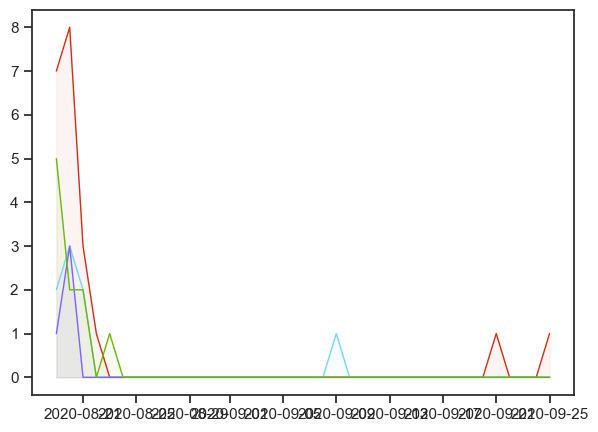

In [88]:
for i in range(len(towns)):

    gdf_copy = towns[i].copy()
    gdf_copy = gdf_copy[gdf_copy['aspect_ter'].str.contains(pattern, case=False, na=False)]
    gdf_copy['date'] = pd.to_datetime(gdf_copy['date'])
    gdf_copy['date'] = gdf_copy['date'].dt.date    # Extract the date part (without time)
    gdf0_counts = gdf_copy.groupby(['date', 'aspect_emo']).size().unstack(fill_value=0)

    date_range = pd.date_range(start=gdf_copy['date'].min(), end=gdf_copy['date'].max())    # Create a complete date range from the minimum to the maximum date

    gdf0_counts = gdf0_counts.reindex(date_range, fill_value=0)    # Reindex to include all dates within the range, filling missing dates with 0

    # Plotting each emotion's count as a line
    plt.figure(figsize=(7, 5))

    emotions = ['ANGER', 'SADNESS', 'FEAR', 'HAPPINESS', 'NONE']
    colors = ['#D13013', '#73D7FB', '#7C64FE', '#6ABA01', 'grey']

    for emotion, color in zip(emotions, colors):
        plt.plot(gdf0_counts.index, gdf0_counts[emotion], label=emotion, color=color, linestyle='-', linewidth=1)
        plt.fill_between(gdf0_counts.index, gdf0_counts[emotion], color=color, alpha=0.05)

    plt.xlabel('Date')
    plt.ylabel('Number of Aspect Terms')
    plt.title(f'{names[i]} Emotions Related to {filter} per Day')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
